In [77]:
# Import required libraries
import numpy as np
import pandas as pd
import sweetviz as sw
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import stanza
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [78]:
# convert to pandas dataframe
df = pd.read_json('Data/News_Category_Dataset_IS_course.json', lines=True)

In [79]:
df.shape

(148122, 6)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148122 entries, 0 to 148121
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               148122 non-null  object        
 1   headline           147391 non-null  object        
 2   category           148122 non-null  object        
 3   short_description  147386 non-null  object        
 4   authors            148122 non-null  object        
 5   date               148122 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 6.8+ MB


In [81]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
1,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
2,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20
3,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20
4,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19


In [82]:
df = df.dropna()

In [83]:
# sort out datatypes
# date
df['date'] = pd.to_datetime(df['date'], unit='ms').dt.strftime('%Y')
# headline
df['headline'] = df['headline'].astype(str)
# authors
df['authors'] = df['authors'].astype(str)
# link
df['link'] = df['link'].astype(str)
# short_description
df['short_description'] = df['short_description'].astype(str)
# category as a category
df['category'] = df['category'].astype(str)

# Exploratory Data Analysis

## Missing values

In [84]:
# look for empty strings across all columns
(df == '').sum()

link                     0
headline                 3
category                 0
short_description    11390
authors              24164
date                     0
dtype: int64

In [85]:
((df == '').sum()  / df.shape[0]) * 100

link                  0.000000
headline              0.002046
category              0.000000
short_description     7.766527
authors              16.476765
date                  0.000000
dtype: float64

In [86]:
# replace empty strings with null
df = df.replace(r'^\s*$', np.nan, regex=True)

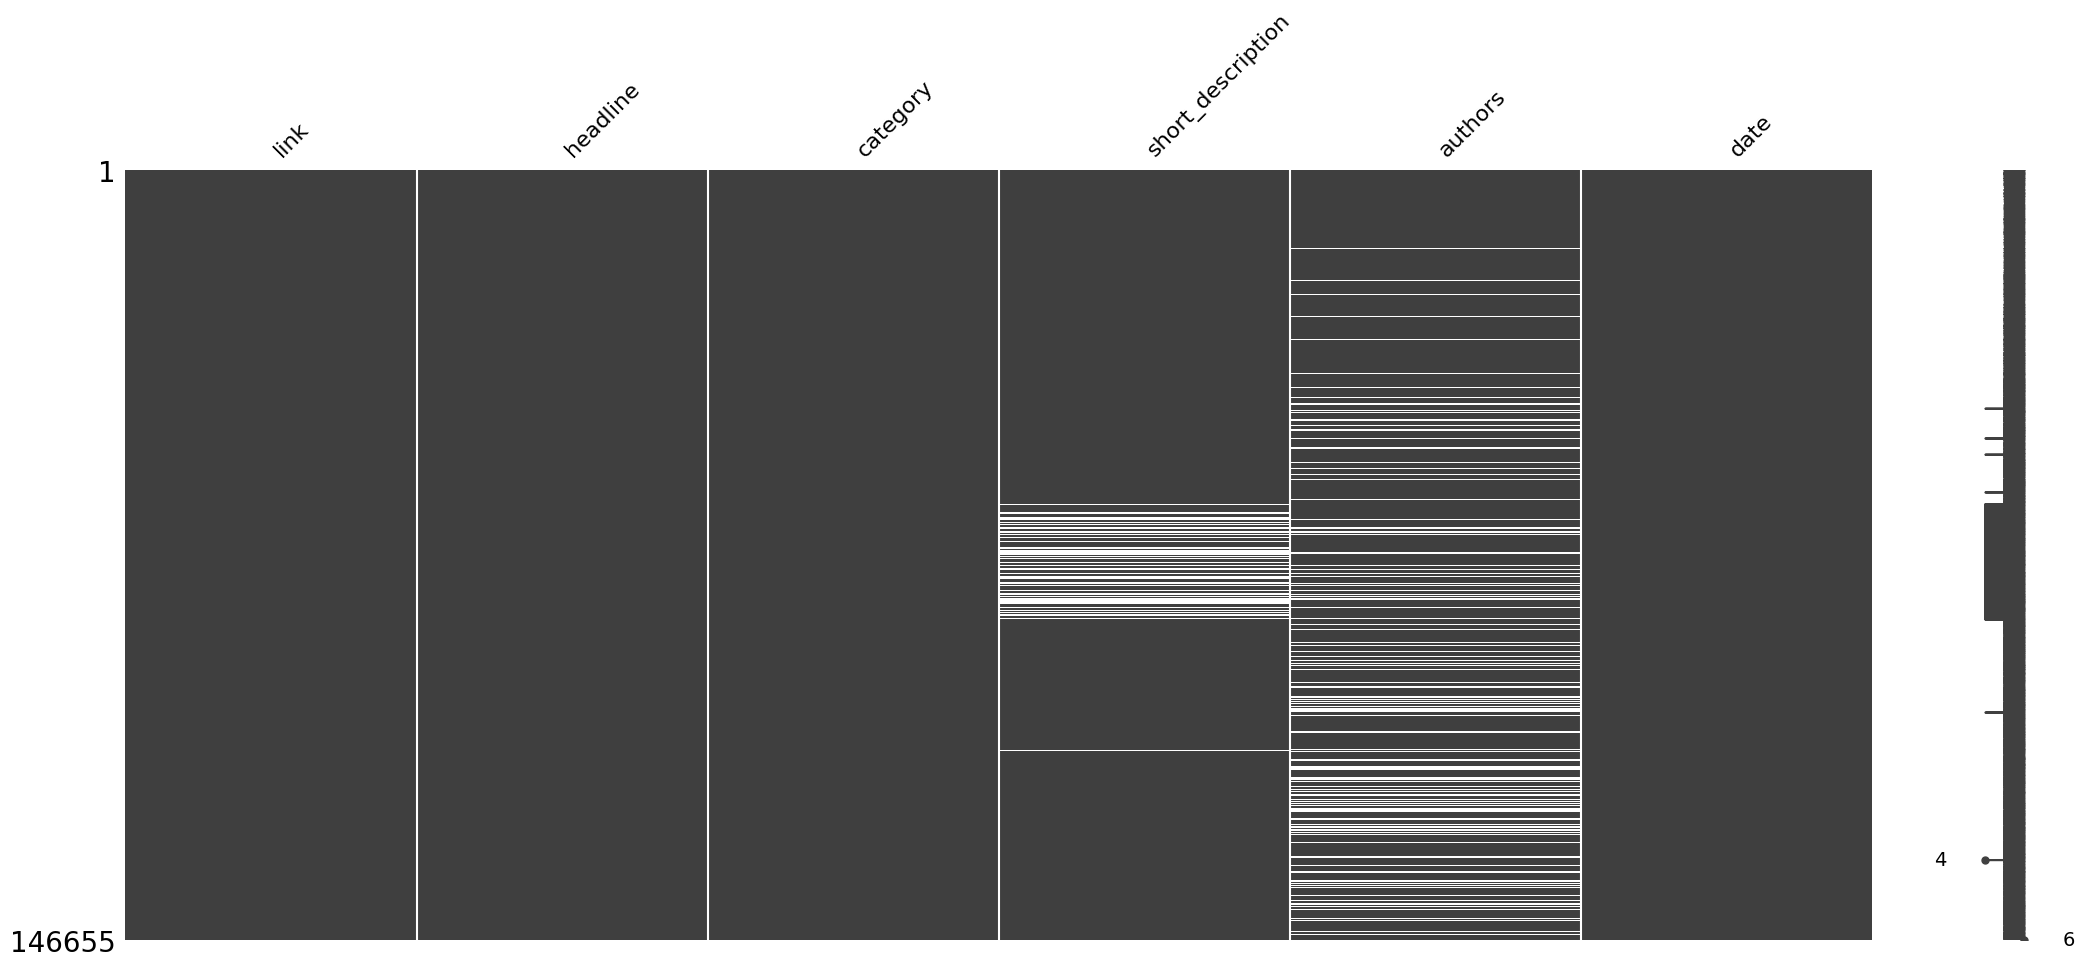

In [87]:
import missingno as msno
import matplotlib.pyplot as plt

# Visualize missing values
msno.matrix(df)
plt.show()

In [88]:
df.groupby('category').size()

category
BLACK VOICES       4530
BUSINESS           5940
COMEDY             5349
ENTERTAINMENT     17185
FOOD & DRINK       6274
HEALTHY LIVING     6623
HOME & LIVING      4272
PARENTING          8708
PARENTS            3922
POLITICS          35233
QUEER VOICES       6280
SPORTS             5036
STYLE & BEAUTY     9731
TRAVEL             9810
WELLNESS          17762
dtype: int64

Text(0, 0.5, 'Count')

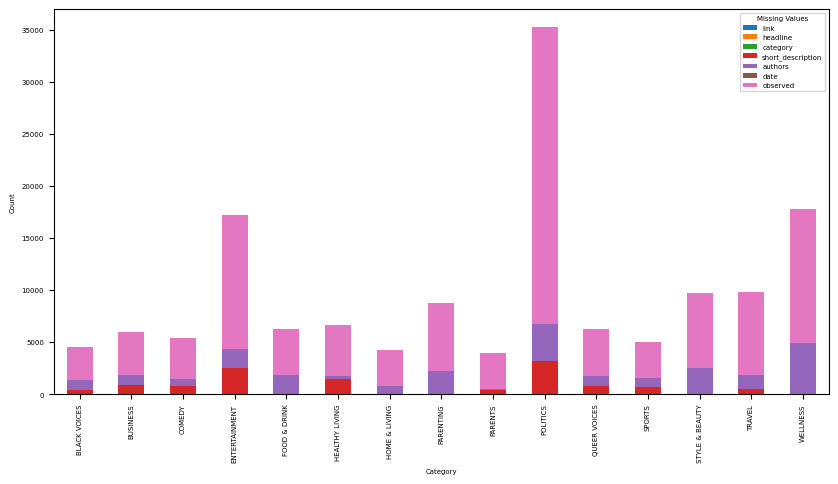

In [89]:
# plot missing values counts across each category

# count missing values in each category
missing_values_count = df.groupby('category').apply(lambda x: x.isnull().sum())
# add a column for total observations in category
missing_values_count['observed'] = df.groupby('category').size() - missing_values_count.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))

# stacked bar chart
missing_values_count.plot.bar(ax=ax, stacked=True)
plt.xlabel('Category')
plt.legend(title = 'Missing Values', loc='upper right')
plt.ylabel('Count')

Text(0, 0.5, 'Percentage')

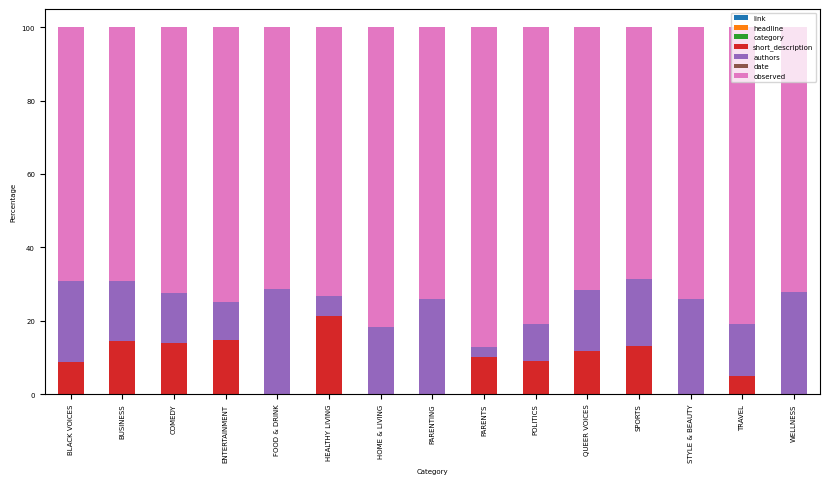

In [90]:
# plot missing values counts across each category

# count missing values in each category
missing_values_count = df.groupby('category').apply(lambda x: x.isnull().sum())
# add a column for total observations in category
missing_values_count['observed'] = df.groupby('category').size() - missing_values_count.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))

# Divide by row total
missing_values_count = missing_values_count.div(missing_values_count.sum(axis=1), axis=0) * 100

# Stacked bar chart
missing_values_count.plot.bar(ax=ax, stacked=True)
plt.xlabel('Category')
plt.ylabel('Percentage')

In [91]:
# Hacky but convert back to "" for now so rest of code works
df = df.replace(np.nan, '', regex=True)

In [92]:
print(df[(df['authors'] == '') & (df['short_description'] == '') & (df['headline'] == '')].shape[0])
print(df[(df['authors'] == '') & (df['short_description'] == '')].shape[0])

0
2238


In [93]:
df[df['headline'] == '']

,link,headline,category,short_description,authors,date
62046,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",2015
72619,https://www.huffingtonpost.com/entry/disney-ce...,,BUSINESS,,"Gary Snyder, ContributorWriter and Media Strat...",2015
80016,https://www.huffingtonpost.com/entry/beverly-h...,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat...",2014


In [94]:
# remove observations with headline as empty string
df = df[df['headline'] != '']
# because the missing short description are only 7% of dataset and in my opinion (Oskar) are necessary for the proper classification I decided to drop them
df = df[df['short_description'] != '']
# the missing authors after cleaning the descriptions are still 17% and we can probably get some classification put of the description, I decided to leave them in the dataset
df = df[df['authors'] != '']

In [95]:
# check all missing values have been removed
((df == '').sum()  / df.shape[0]) * 100

link                 0.0
headline             0.0
category             0.0
short_description    0.0
authors              0.0
date                 0.0
dtype: float64

Insights:
- There is missingness
- Mostly in Short description and Author (and sometimes both are missing)
- Only in 3 observations is there no headline and in all cases there is no short-description

### Category

In [96]:
df['category'].value_counts()

category
POLITICS          29373
ENTERTAINMENT     13330
WELLNESS          12808
TRAVEL             7953
STYLE & BEAUTY     7215
PARENTING          6456
HEALTHY LIVING     5018
QUEER VOICES       4661
FOOD & DRINK       4481
BUSINESS           4333
COMEDY             3901
SPORTS             3584
HOME & LIVING      3488
PARENTS            3462
BLACK VOICES       3276
Name: count, dtype: int64

In [97]:
df['category'].value_counts() / df.shape[0] * 100

category
POLITICS          25.916057
ENTERTAINMENT     11.761177
WELLNESS          11.300611
TRAVEL             7.017002
STYLE & BEAUTY     6.365858
PARENTING          5.696186
HEALTHY LIVING     4.427426
QUEER VOICES       4.112441
FOOD & DRINK       3.953626
BUSINESS           3.823044
COMEDY             3.441887
SPORTS             3.162195
HOME & LIVING      3.077493
PARENTS            3.054553
BLACK VOICES       2.890444
Name: count, dtype: float64

In [98]:
counts = df['category'].value_counts()
cat_df = pd.DataFrame({'category': counts.index, 'count': counts.values})

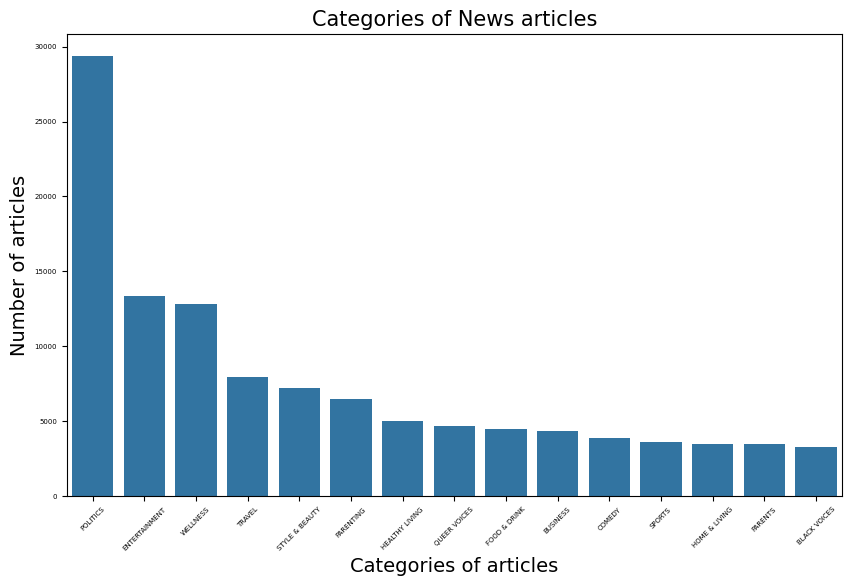

,category,count
0,POLITICS,29373
1,ENTERTAINMENT,13330
2,WELLNESS,12808
3,TRAVEL,7953
4,STYLE & BEAUTY,7215
5,PARENTING,6456
6,HEALTHY LIVING,5018
7,QUEER VOICES,4661
8,FOOD & DRINK,4481
9,BUSINESS,4333


In [99]:
# Visualize top 10 categories and proportion of each category's in dataset
plt.figure(figsize=(10,6))
df_sorted = cat_df.sort_values(by='count', ascending=False)
sns.barplot(x='category', y='count', data=df_sorted, order=df_sorted['category'])
plt.title("Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()
cat_df

#### Combine similar categories

In [100]:
df['category'] = df['category'].replace('PARENTING', 'PARENTS')
df['category'] = df['category'].replace('HEALTHY LIVING', 'WELLNESS')
df['category'] = df['category'].replace('COMEDY', 'ENTERTAINMENT')
df['category'] = df['category'].replace('BLACK VOICES', 'MINORITY VOICES')
df['category'] = df['category'].replace('QUEER VOICES', 'MINORITY VOICES')

In [101]:
counts = df['category'].value_counts()
cat_df = pd.DataFrame({'category': counts.index, 'count': counts.values})

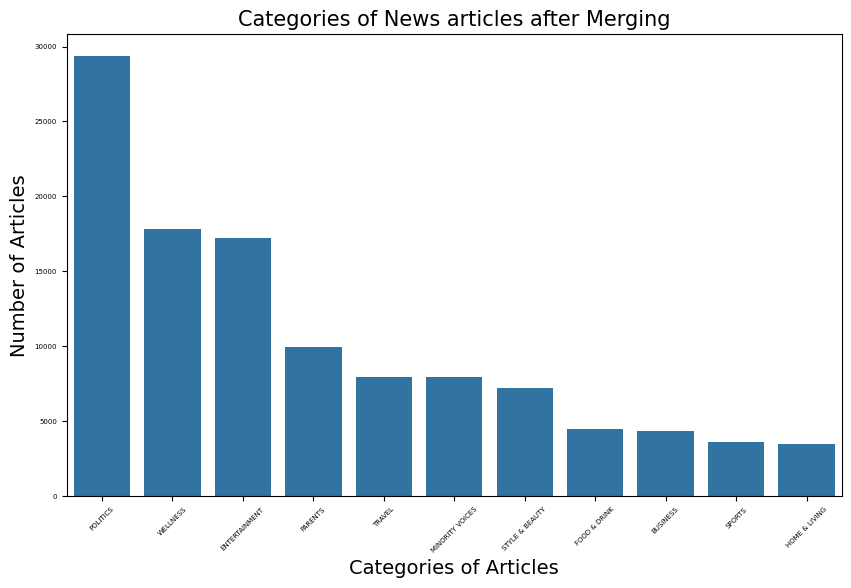

,category,count
0,POLITICS,29373
1,WELLNESS,17826
2,ENTERTAINMENT,17231
3,PARENTS,9918
4,TRAVEL,7953
5,MINORITY VOICES,7937
6,STYLE & BEAUTY,7215
7,FOOD & DRINK,4481
8,BUSINESS,4333
9,SPORTS,3584


In [102]:
# Visualize top 10 categories and proportion of each category's in dataset
plt.figure(figsize=(10,6))
df_sorted = cat_df.sort_values(by='count', ascending=False)
sns.barplot(x='category', y='count', data=df_sorted, order=df_sorted['category'])
plt.title("Categories of News articles after Merging", size=15)
plt.xlabel("Categories of Articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Articles", size=14)
plt.show()
cat_df

### Authors

In [103]:
#This is taking only the words until the first comma, it destroys few entries where there are two authors separated by comma, but it is not often, so we can leave with that
def extract_text(row):
    comma_index = row.find(',')
    semicolon_index = row.find(';')
    parenthesis_index = row.find('(')
    indices = [index for index in [comma_index, semicolon_index, parenthesis_index] if index != -1]
    if indices:
        min_index = min(indices)
        return row[:min_index]
    else:
        return row

In [104]:
df_authors = df.copy()

In [105]:
# Percentage of authors with less than 10 articles
(df['authors'].value_counts() < 10).sum() / df.shape[0] * 100

15.487166818129683

In [106]:
df['authors'].value_counts()

authors
Lee Moran                                                                                          2031
Ron Dicker                                                                                         1633
Cole Delbyck                                                                                       1253
Reuters, Reuters                                                                                   1128
Mary Papenfuss                                                                                     1103
                                                                                                   ... 
Meerabelle Dey, ContributorWriter, columnist for Beliefnet and co-founder of the blog, La...          1
Broderick Johnson, Contributor Assistant to the President and Cabinet Secretary; Chair of th...       1
Paul Loeb, ContributorAuthor, 'Soul of a Citizen' and 'The Impossible Will Take a Li...               1
Kara Sundlun, ContributorNews Anchor, Talk Show Host, Au

In [107]:
df[df['authors'].str.len() > 50]

,link,headline,category,short_description,authors,date
81,https://www.huffpost.com/entry/biden-student-l...,Student Loan Borrowers Await Biden Plan On Deb...,POLITICS,If Biden's plan survives legal challenges that...,"Seung Min Kim, Michael Balsamo, Chris Megerian...",2022
86,https://www.huffpost.com/entry/after-delay-bid...,"After Delay, Biden Readies Student Loan Help, ...",POLITICS,The precise details of President Joe Biden’s p...,"Seung Min Kim, Michael Balsamo and Chris Meger...",2022
792,https://www.huffpost.com/entry/trump-tweets-ra...,The Best And Worst Trump Tweets Over The Past ...,POLITICS,Here you go.,"Amanda Terkel, Paige Lavender, Richard Kim, an...",2022
1222,https://www.huffpost.com/entry/police-say-they...,Police Say They’re Ready For Rally Supporting ...,POLITICS,The Capitol police are taking no chances as th...,"By Colleen Long, Michael Balsamo and Ashraf Kh...",2021
1298,https://www.huffpost.com/entry/taliban-us-airs...,U.S. Drone Strike Kills Suicide Bombers Target...,POLITICS,The strike hit a vehicle carrying “multiple su...,"Kathy Gannon, Lolita C. Baldor, Tameem Akhgar ...",2021
...,...,...,...,...,...,...
148106,https://www.huffingtonpost.com/entry/gay-divor...,Gay Divorce: How the Collaborative Family Law ...,MINORITY VOICES,One of the many unjust results of a state lega...,"Thomas Greenwald, Contributor\nPartner, Gorans...",2012
148107,https://www.huffingtonpost.com/entry/the-six-p...,Episode 87: Life Is a Highway (AUDIO),MINORITY VOICES,"On this episode of The Six Pack, we hit up the...","The Six Pack, Contributor\nRadio show hosted b...",2012
148111,https://www.huffingtonpost.com/entry/four-more...,Four More Bank Closures Mark the Week of Janua...,BUSINESS,The general pattern of the FDIC closing banks ...,"Dennis Santiago, Contributor\nGlobal Risk and ...",2012
148114,https://www.huffingtonpost.com/entry/world-eco...,"At World Economic Forum, Fear of Global Contag...",BUSINESS,"For decades, as crises have assailed developin...","Peter S. Goodman, Contributor\nExecutive Busin...",2012


In [108]:
# look at the relationship between authors and category
# for top 100 authors
# get top 100 authors
top_100_authors = df['authors'].value_counts()[1:101].index.tolist()
# look at the distribution of categories for each of these authors
df_top_100_authors = df[df['authors'].isin(top_100_authors)]

# Calculate the total number of publications for each author
author_total_publications = df_top_100_authors.groupby('authors').size().sort_values(ascending=False)

df_top_100_authors.groupby(['authors', 'category']).size()

authors                category       
Alana Horowitz Satlin  BUSINESS            16
                       ENTERTAINMENT       16
                       MINORITY VOICES      8
                       PARENTS              1
                       POLITICS           179
                                         ... 
Zach Carter            BUSINESS             1
                       ENTERTAINMENT        3
                       POLITICS           191
Zeba Blay              ENTERTAINMENT       10
                       MINORITY VOICES    173
Length: 423, dtype: int64

In [109]:
# for Elyse Wanshel get the distribution of categories
df[df['authors'] == 'Elyse Wanshel']['category'].value_counts()

category
ENTERTAINMENT      322
MINORITY VOICES     59
POLITICS            23
PARENTS             18
WELLNESS             7
SPORTS               4
TRAVEL               3
STYLE & BEAUTY       1
BUSINESS             1
Name: count, dtype: int64

<Axes: xlabel='authors'>

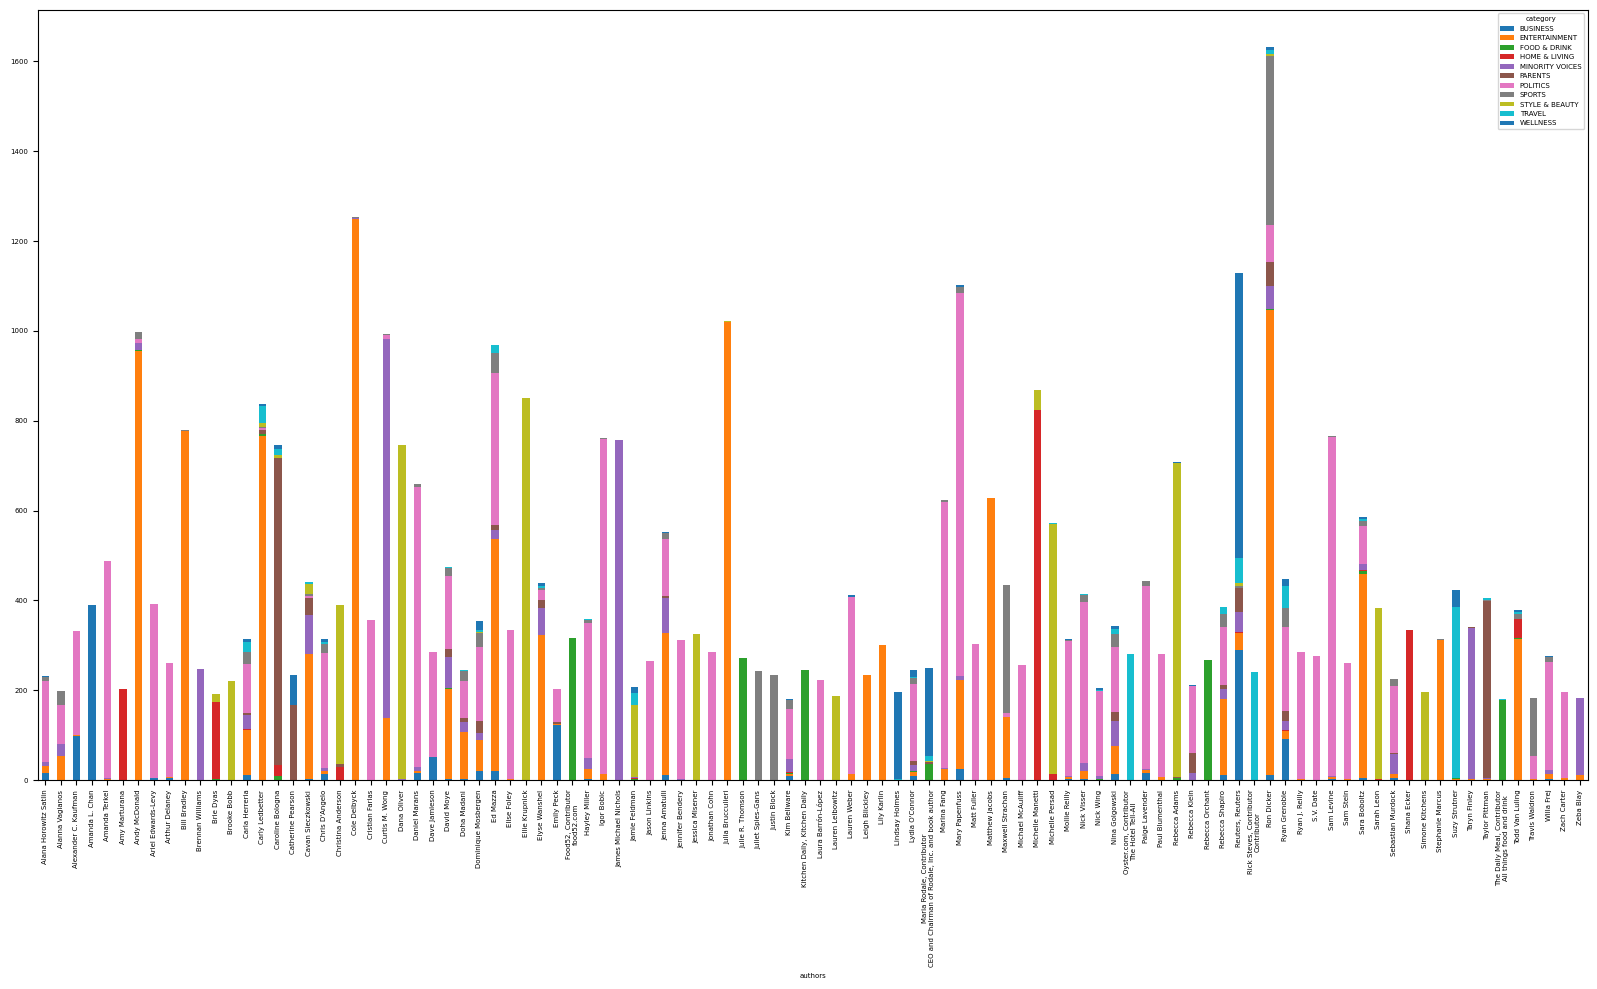

In [110]:
# plot the distribution of categories for top 100 authors
df_top_100_authors.groupby(['authors', 'category']).size().unstack().plot(kind='bar', stacked=True, figsize=(20, 10))

Insights:
- Some authors are just names whereas others have descriptions of the author
- Further some other authors are actually institutions rather than individuals
- There are a lot of authors that have more than one article in the dataset - almost 90% of authors have over 10 articles
- Author seems like it could be a useful predictor of Category
- There is a fair amount of missing data! How to resolve this!


### Link

In [111]:
# extract the website name from the link using regex
import re
df['website'] = df['link'].apply(lambda x: re.findall(r'(?<=www.)[^/]+', x)[0])

In [112]:
df['website'].unique().shape[0] / df.shape[0] * 100

0.0017646176514703675

In [113]:
df['website'].value_counts()

website
huffingtonpost.com    108174
huffpost.com            5165
Name: count, dtype: int64

Insight:
- Link is not useful all links are from huffingtonpost - should've known that :(
- Any other information in the link is covered by the heading

### Date

In [114]:
counts = df['date'].value_counts()
cat_df = pd.DataFrame({'date': counts.index, 'count': counts.values})

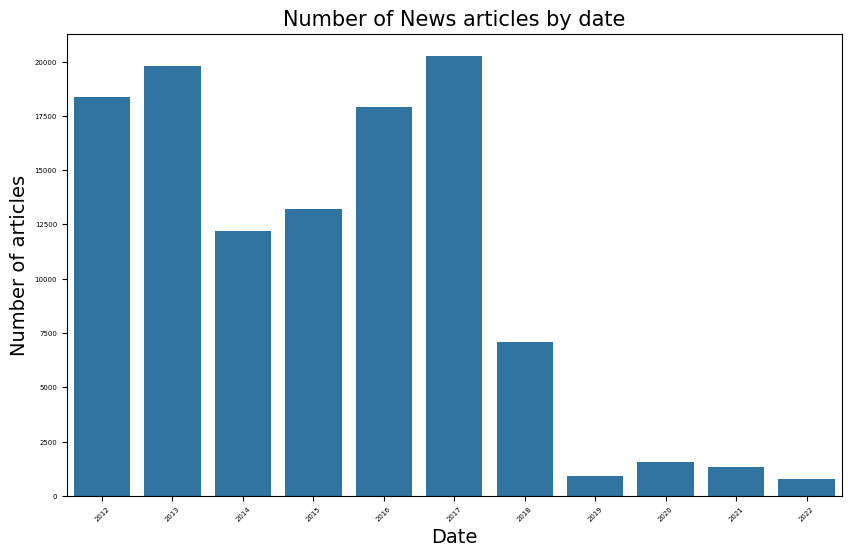

In [115]:
cat_df = cat_df.sort_values(by='date')
plt.figure(figsize=(10,6))
sns.barplot(x='date', y='count', data=cat_df)
plt.title("Number of News articles by date", size=15)
plt.xlabel("Date", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

Text(0, 0.5, 'Count')

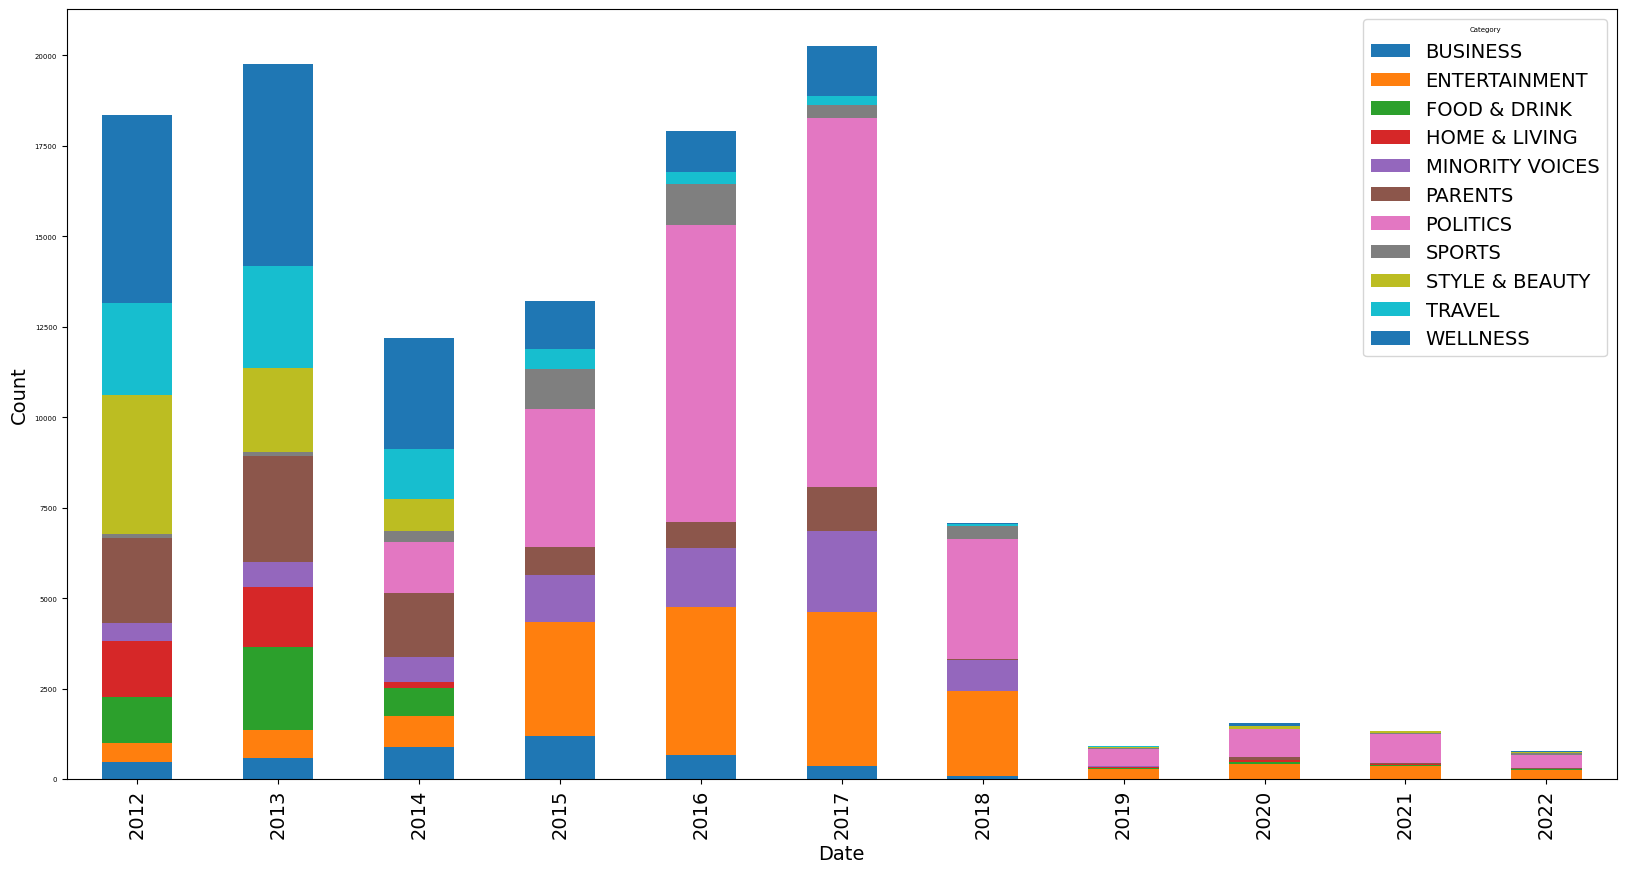

In [116]:
# count number of categories of articles for each date
df_date_category = df.groupby(['date', 'category']).size().unstack()

# set a color palette with 15 colors
palette = sns.color_palette("tab20", 15)

# plot the number of categories of articles for each date
fig, ax = plt.subplots(figsize=(20, 10))
df_date_category.plot.bar(ax=ax, stacked=True)
# set text size to 14
plt.xticks(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Category', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Count')


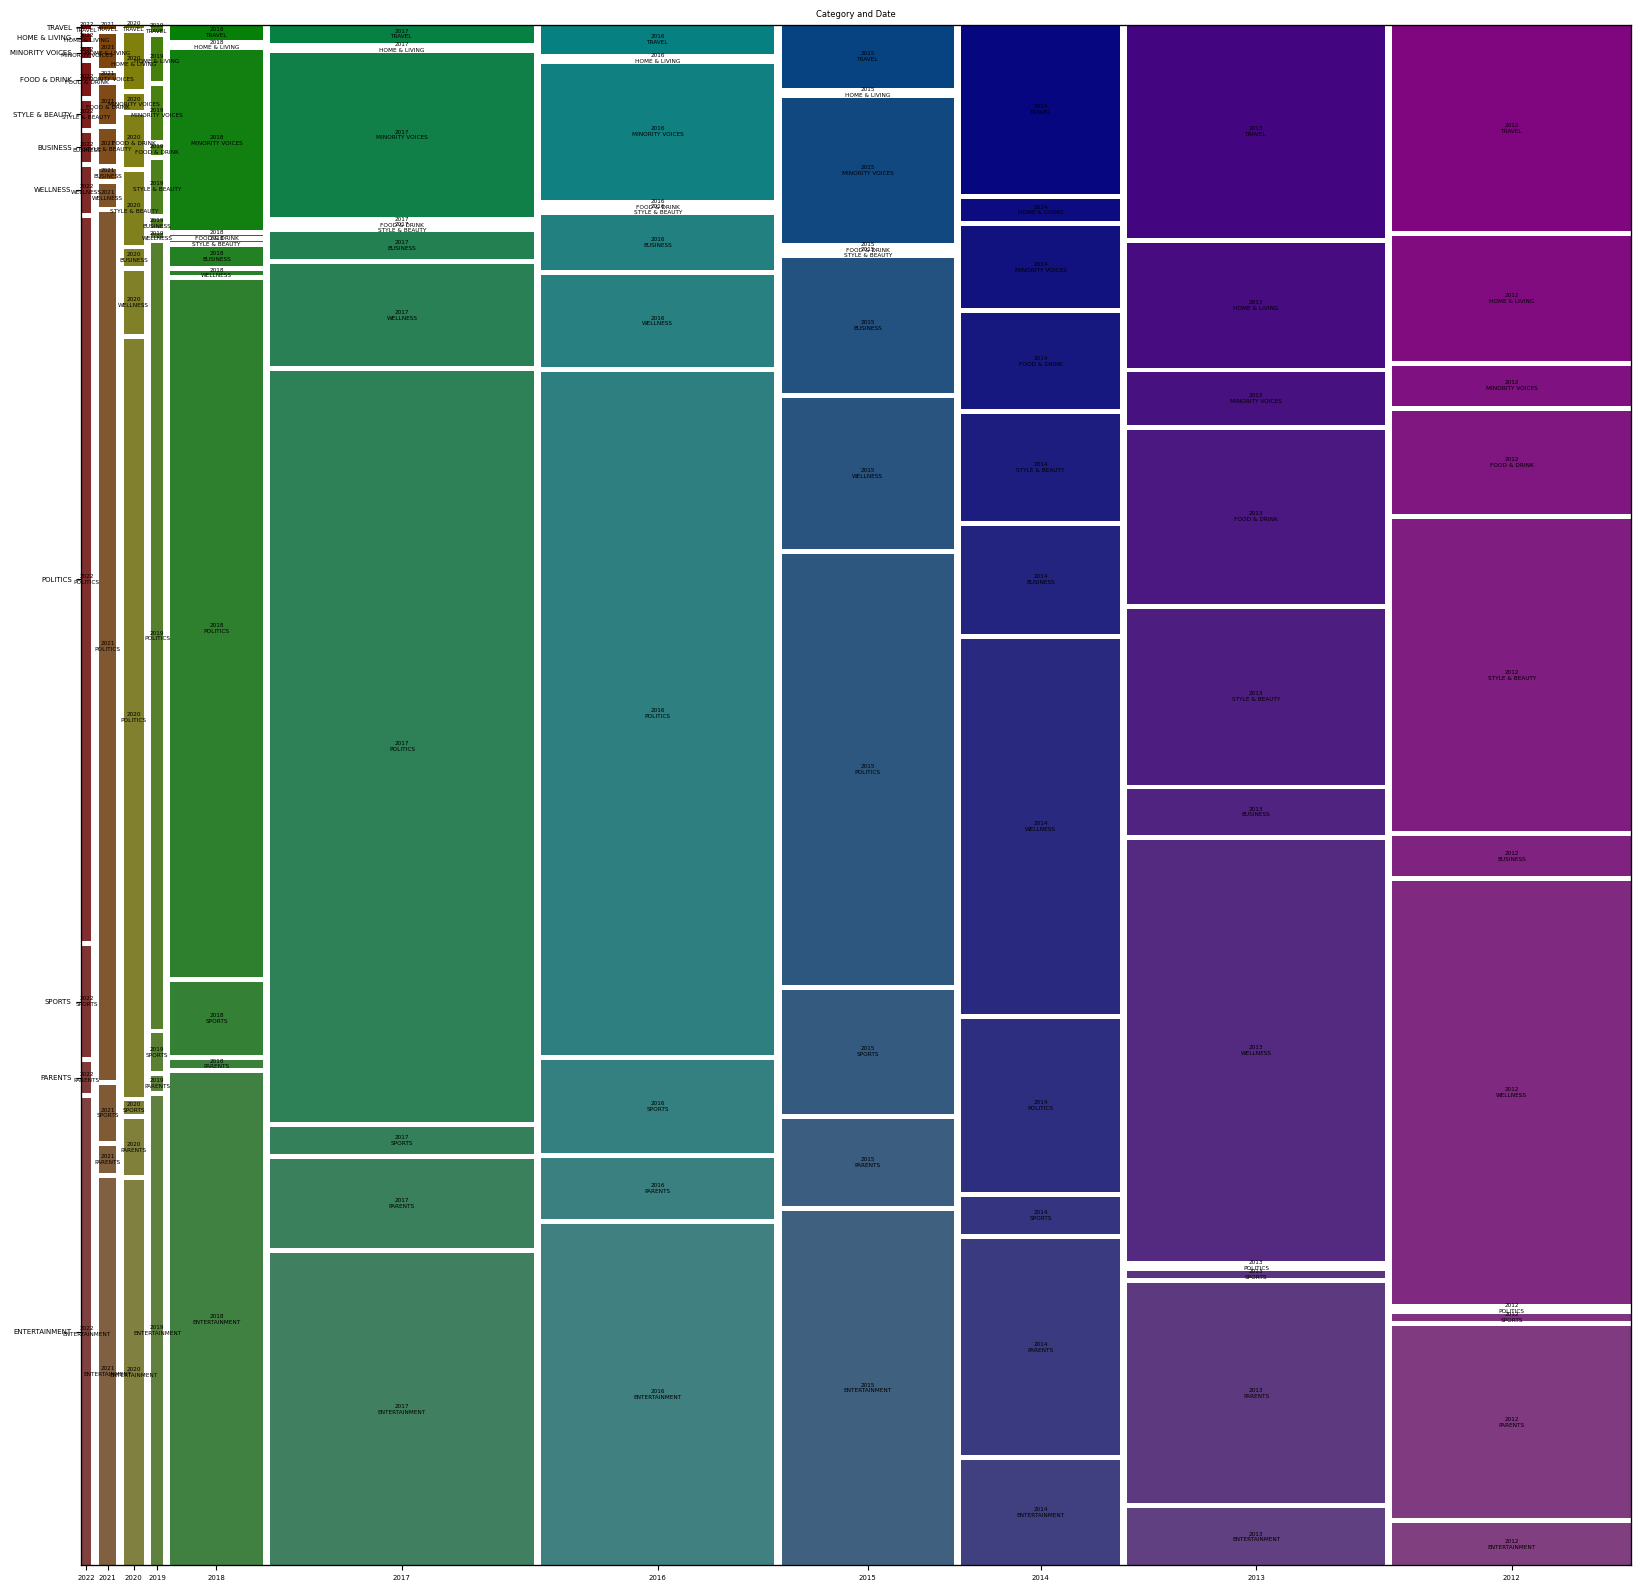

In [117]:
# association between date and category
# for each category, get the distribution of dates
fig, ax = plt.subplots(figsize=(20, 20))
df.groupby(['category', 'date']).size()
# plot as mosaic plot
from statsmodels.graphics.mosaicplot import mosaic

df_up_to_2017 = df[df['date'] <= '2017']

(ax, _) = mosaic(df, ['date', 'category'], ax=ax, title='Category and Date')
plt.rcParams['font.size'] = 5
plt.show()
plt.rcParams['font.size'] = 14

# Data Wranling

In [118]:
# drop unnecessary features
df.drop(['website'], axis=1, inplace=True)
# no link
df.drop(['link'], axis=1, inplace=True)

In [119]:
df.shape

(113339, 5)

In [120]:
df['category'].value_counts()

category
POLITICS           29373
WELLNESS           17826
ENTERTAINMENT      17231
PARENTS             9918
TRAVEL              7953
MINORITY VOICES     7937
STYLE & BEAUTY      7215
FOOD & DRINK        4481
BUSINESS            4333
SPORTS              3584
HOME & LIVING       3488
Name: count, dtype: int64

# Preprocessing

In [121]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Download necessary resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oskik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oskik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oskik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [122]:
# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())  # Convert text to lowercase

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [word.translate(table) for word in words if word.isalpha()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(lemmatized_words)

    # Stemming (uncomment if you want to use stemming)
    # stemmed_words = [stemmer.stem(word) for word in words]
    # preprocessed_text = ' '.join(stemmed_words)

    return preprocessed_text

In [123]:
# Apply the function to preprocess the text
df['headline_clean'] = df['headline'].apply(preprocess_text)
df['short_description_clean'] = df['short_description'].apply(preprocess_text)
# pre-process authors as well
df['authors_clean'] = df['authors'].apply(preprocess_text)

In [124]:
df = df[['headline_clean', 'short_description_clean', 'authors_clean', 'category']]

# 10% of data

In [125]:
df_full = df

In [126]:
# take a sample of the data where we have 10% of the data evenly distributed across categories
df = df.groupby('category').sample(frac=0.1, random_state=42)

## Test and Training Split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(df[['headline_clean', 'short_description_clean', 'authors_clean']],
                                                    df['category'], 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=df['category']
)

In [128]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df_full[['headline_clean', 'short_description_clean', 'authors_clean']],
                                                    df_full['category'], 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=df_full['category']
)

# Text Vectorisation

### Chat-GPT which to use?

Seems to suggest TF-IDF might be appropriate

## TF-IDF Approach

In [129]:
X_train['short_description_clean'].head()

22677    military family raised ready anything working ...
54047    early miscarriage couple try conceive within t...
19098    donald trump continued crusade earlier week un...
9027     clear response resource needed people waiting ...
80867    depression something taken lightly willed away...
Name: short_description_clean, dtype: object

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Import required libraries
# Model building: Choose and train a classifier
vectorizer = TfidfVectorizer()  # Use TF-IDF vectorizer for text to numerical feature conversion


In [131]:
# attempt to merge features
X_train_vec = vectorizer.fit_transform(X_train['headline_clean'] + ' ' + X_train['short_description_clean'] + ' ' + X_train['authors_clean'])
X_test_vec = vectorizer.transform(X_test['headline_clean'] + ' ' + X_test['short_description_clean'] + ' ' + X_test['authors_clean'])

In [132]:
X_train_full_vec = vectorizer.fit_transform(X_train_full['headline_clean'] + ' ' + X_train_full['short_description_clean'] + ' ' + X_train_full['authors_clean'])
X_test_full_vec = vectorizer.transform(X_test_full['headline_clean'] + ' ' + X_test_full['short_description_clean'] + ' ' + X_test_full['authors_clean'])

### Word Cloud

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming train_texts is a list containing your training texts
# train_labels is a list containing corresponding class labels
train_texts = (X_train['headline_clean'] + ' ' + X_train['short_description_clean'] + ' ' + X_train['authors_clean']).tolist()
train_labels = y_train.tolist()

# get unique labels
class_labels = set(train_labels)
class_labels = ['BUSINESS', 'POLITICS']
# Generate word clouds for each class
# TF-IDF
vectorizer = TfidfVectorizer()

for label in class_labels:
    # Get the indices of instances for the current class
    indices_for_class = [i for i, lbl in enumerate(train_labels) if lbl == label]

    # Combine the texts for the current class
    combined_texts = [train_texts[i] for i in indices_for_class]

    # Transform the combined texts using TF-IDF vectorizer
    combined_texts_vec = vectorizer.fit_transform(combined_texts)

    # Extract feature names and TF-IDF scores
    feature_names = vectorizer.get_feature_names_out()
    tfidf_dict = dict(zip(feature_names, combined_texts_vec.sum(axis=0).A1))

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_dict)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Class: {label}')
    plt.axis('off')
    plt.show()

ModuleNotFoundError: No module named 'wordcloud'

#### Basic Classification Methods

##### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Logistic Regression model (1:14)
logistic_model = LogisticRegression(max_iter=1000) # increase iterations to help with convergence (default is 100)
logistic_model.fit(X_train_vec, y_train)
logistic_predictions = logistic_model.predict(X_test_vec)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
print("Logistic Regression Accuracy:", logistic_accuracy)

Logistic Regression Accuracy: 0.7673469387755102


In [ ]:
from sklearn.linear_model import LogisticRegression

# logistic regression but using cv and not test set to get accuracy
logistic_model = LogisticRegression(max_iter=1000) # increase iterations to help with convergence (default is 100)
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
logistic_accuracy = []
logistic_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    logistic_model.fit(X_train_cv, y_train_cv)
    logistic_predictions = logistic_model.predict(X_test_cv)
    logistic_accuracy.append(accuracy_score(y_test_cv, logistic_predictions))
    logistic_train_predictions = logistic_model.predict(X_train_cv)
    logistic_train_accuracy.append(accuracy_score(y_train_cv, logistic_train_predictions))

# compute mean accuracy
logistic_accuracy = np.mean(logistic_accuracy)
logistic_train_accuracy = np.mean(logistic_train_accuracy)
print("Logistic Regression Accuracy:", logistic_accuracy)
print("Logistic Regression Train Accuracy:", logistic_train_accuracy)


Logistic Regression Accuracy: 0.7594589729571617
Logistic Regression Train Accuracy: 0.9026966128806079


6.5 seconds on 10%

In [ ]:
# training accuracy
logistic_predictions_train = logistic_model.predict(X_train_vec)
logistic_accuracy_train = accuracy_score(y_train, logistic_predictions_train)
print("Logistic Regression Training Accuracy:", logistic_accuracy_train)

Logistic Regression Training Accuracy: 0.9698364008179959


In [ ]:
# Classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, logistic_predictions))

                 precision    recall  f1-score   support

       BUSINESS       0.78      0.53      0.63        40
   FOOD & DRINK       1.00      0.64      0.78        47
  HOME & LIVING       1.00      0.47      0.63        43
MINORITY VOICES       0.72      0.85      0.78        71
        PARENTS       0.71      0.93      0.81       107
         SPORTS       0.89      0.47      0.62        34
 STYLE & BEAUTY       0.75      0.85      0.80        68
         TRAVEL       0.75      0.89      0.81        80

       accuracy                           0.77       490
      macro avg       0.83      0.70      0.73       490
   weighted avg       0.80      0.77      0.76       490



Text(0, 0.5, 'True Positive Rate')

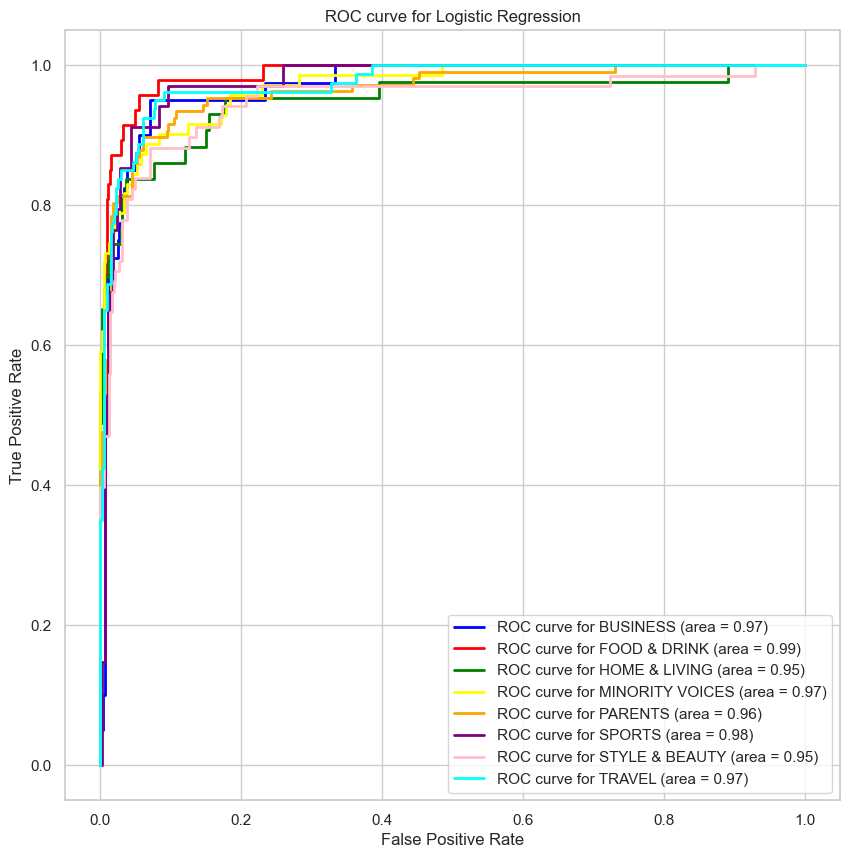

In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
# plot the ROC curve
y_test_bin = label_binarize(y_test, classes=logistic_model.classes_)
y_score = logistic_model.decision_function(X_test_vec)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# plot the curves
plt.figure(figsize=(10, 10))
colors = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'cyan', 'magenta', 'brown']
for (idx, color) in zip(range(n_classes), colors):
    plt.plot(fpr[idx], tpr[idx], color=color, lw=2, label='ROC curve for {} (area = {:.2f})'.format(logistic_model.classes_[idx], roc_auc[idx]))
# add legend
plt.legend(loc='lower right')
# add title and axis labels
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

##### KNN

In [ ]:
# kNN model
# TODO: cross-validation to find the best k (7:11)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_vec, y_train)
knn_predictions = knn_model.predict(X_test_vec)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("kNN Accuracy:", knn_accuracy)

kNN Accuracy: 0.7408163265306122


3 seconds on 10%

In [ ]:
# training accuracy
knn_predictions_train = knn_model.predict(X_train_vec)
knn_accuracy_train = accuracy_score(y_train, knn_predictions_train)
print("kNN Training Accuracy:", knn_accuracy_train)

kNN Training Accuracy: 0.8384458077709611


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# kNN model
knn_model = KNeighborsClassifier(n_neighbors=9)
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn_accuracy = []
knn_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    knn_model.fit(X_train_cv, y_train_cv)
    knn_predictions = knn_model.predict(X_test_cv)
    knn_accuracy.append(accuracy_score(y_test_cv, knn_predictions))
    knn_train_predictions = knn_model.predict(X_train_cv)
    knn_train_accuracy.append(accuracy_score(y_train_cv, knn_train_predictions))

# compute mean accuracy
knn_accuracy = np.mean(knn_accuracy)
knn_train_accuracy = np.mean(knn_train_accuracy)
print("kNN Accuracy:", knn_accuracy)
print("kNN Train Accuracy:", knn_train_accuracy)


kNN Accuracy: 0.74920070713109
kNN Train Accuracy: 0.8137477657249231


KNN prediction on train takes 9 seconds (longer than fitting)

##### Naive Bayes

In [ ]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_predictions = nb_model.predict(X_test_vec)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes Accuracy:", nb_accuracy)

Naive Bayes Accuracy: 0.6204081632653061


In [ ]:
# training accuracy
nb_predictions_train = nb_model.predict(X_train_vec)
nb_accuracy_train = accuracy_score(y_train, nb_predictions_train)
print("Naive Bayes Training Accuracy:", nb_accuracy_train)

Naive Bayes Training Accuracy: 0.8624744376278118


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes model
nb_model = MultinomialNB()
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
nb_accuracy = []
nb_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    nb_model.fit(X_train_cv, y_train_cv)
    nb_predictions = nb_model.predict(X_test_cv)
    nb_accuracy.append(accuracy_score(y_test_cv, nb_predictions))
    nb_train_predictions = nb_model.predict(X_train_cv)
    nb_train_accuracy.append(accuracy_score(y_train_cv, nb_train_predictions))

# compute mean accuracy
nb_accuracy = np.mean(nb_accuracy)
nb_train_accuracy = np.mean(nb_train_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Train Accuracy:", nb_train_accuracy)


Naive Bayes Accuracy: 0.5681047877299256
Naive Bayes Train Accuracy: 0.6942484653394043


0.1 second on 10%

##### SVM

In [138]:
# SVM model
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC
svm_model = SVC(kernel='linear') # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVM Accuracy: 0.8253198059108955


1 min 20 on 10%

In [139]:
# training accuracy
svm_predictions_train = svm_model.predict(X_train_vec)
svm_accuracy_train = accuracy_score(y_train, svm_predictions_train)
print("SVM Training Accuracy:", svm_accuracy_train)

SVM Training Accuracy: 0.9809198191242969


In [140]:
from sklearn.svm import SVC

# SVM model
svm_model = SVC(kernel='linear') # default kernel is rbf and default C is 1.0
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm_accuracy = []
svm_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    svm_model.fit(X_train_cv, y_train_cv)
    svm_predictions = svm_model.predict(X_test_cv)
    svm_accuracy.append(accuracy_score(y_test_cv, svm_predictions))
    svm_train_predictions = svm_model.predict(X_train_cv)
    svm_train_accuracy.append(accuracy_score(y_train_cv, svm_train_predictions))

# compute mean accuracy
svm_accuracy = np.mean(svm_accuracy)
svm_train_accuracy = np.mean(svm_train_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("SVM Train Accuracy:", svm_train_accuracy)

SVM Accuracy: 0.8039054580084664
SVM Train Accuracy: 0.9829877569651545


SVM prediction takes 37 seconds on train

##### Decision Tree

In [371]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train)
predicted_dt = dt.predict(X_test_vec)
accuracy_dt = accuracy_score(y_test, predicted_dt)
print("Decision Tree Accuracy:", accuracy_dt)

Decision Tree Accuracy: 0.6469387755102041


15 seconds on 10%

In [372]:
# training accuracy
predicted_dt_train = dt.predict(X_train_vec)
accuracy_dt_train = accuracy_score(y_train, predicted_dt_train)
print("Decision Tree Training Accuracy:", accuracy_dt_train)

Decision Tree Training Accuracy: 1.0


In [61]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
dt_model = DecisionTreeClassifier()
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_accuracy = []
dt_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    dt_model.fit(X_train_cv, y_train_cv)
    dt_predictions = dt_model.predict(X_test_cv)
    dt_accuracy.append(accuracy_score(y_test_cv, dt_predictions))
    dt_train_predictions = dt_model.predict(X_train_cv)
    dt_train_accuracy.append(accuracy_score(y_train_cv, dt_train_predictions))

# compute mean accuracy
dt_accuracy = np.mean(dt_accuracy)
dt_train_accuracy = np.mean(dt_train_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree Train Accuracy:", dt_train_accuracy)


Decision Tree Accuracy: 0.6453078373695794
Decision Tree Train Accuracy: 1.0


##### Random Forest

In [373]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
predicted_rf = rf.predict(X_test_vec)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.7816326530612245


1 min 40 on 10%

In [374]:
# training accuracy
predicted_rf_train = rf.predict(X_train_vec)
accuracy_rf_train = accuracy_score(y_train, predicted_rf_train)
print("Random Forest Training Accuracy:", accuracy_rf_train)

Random Forest Training Accuracy: 1.0


In [62]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier()
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_accuracy = []
rf_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    rf_model.fit(X_train_cv, y_train_cv)
    rf_predictions = rf_model.predict(X_test_cv)
    rf_accuracy.append(accuracy_score(y_test_cv, rf_predictions))
    rf_train_predictions = rf_model.predict(X_train_cv)
    rf_train_accuracy.append(accuracy_score(y_train_cv, rf_train_predictions))

# compute mean accuracy
rf_accuracy = np.mean(rf_accuracy)
rf_train_accuracy = np.mean(rf_train_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Train Accuracy:", rf_train_accuracy)

Random Forest Accuracy: 0.7437969436709396
Random Forest Train Accuracy: 1.0


##### Bagging

In [375]:
# Random Forest model
from sklearn.ensemble import BaggingClassifier

model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=14, random_state=8678686)
model_bagging.fit(X_train_vec, y_train)
pred_bagging = model_bagging.predict(X_test_vec)
result_bagging = accuracy_score(y_test, pred_bagging)
print("Bagging Accuracy:", result_bagging)

Bagging Accuracy: 0.6918367346938775


2 min 40 run time on 10%

In [376]:
# training accuracy
pred_bagging_train = model_bagging.predict(X_train_vec)
result_bagging_train = accuracy_score(y_train, pred_bagging_train)
print("Bagging Training Accuracy:", result_bagging_train)

Bagging Training Accuracy: 0.9851738241308794


In [63]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Bagging model
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5, random_state=42)
# 5-fold cross validation manually not using cross_val_score
bagging_accuracy = []
bagging_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    bagging_model.fit(X_train_cv, y_train_cv)
    bagging_predictions = bagging_model.predict(X_test_cv)
    bagging_accuracy.append(accuracy_score(y_test_cv, bagging_predictions))
    bagging_train_predictions = bagging_model.predict(X_train_cv)
    bagging_train_accuracy.append(accuracy_score(y_train_cv, bagging_train_predictions))

# compute mean accuracy
bagging_accuracy = np.mean(bagging_accuracy)
bagging_train_accuracy = np.mean(bagging_train_accuracy)
print("Bagging Accuracy:", bagging_accuracy)
print("Bagging Train Accuracy:", bagging_train_accuracy)


c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: Futu

Bagging Accuracy: 0.6841310247988466
Bagging Train Accuracy: 0.9559666648306278


##### Boosting

Attempting Gradient Boosting classification (a boosting method)

In [377]:
# Gradient Boosting model
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_vec, y_train)
gb_predictions = gb_model.predict(X_test_vec)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.7653061224489796


11 min run time on 10%

In [378]:
# train accuracy
gb_predictions_train = gb_model.predict(X_train_vec)
gb_accuracy_train = accuracy_score(y_train, gb_predictions_train)
print("Gradient Boosting Training Accuracy:", gb_accuracy_train)

Gradient Boosting Training Accuracy: 0.995398773006135


In [64]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting model
gb_model = GradientBoostingClassifier()
# 5-fold cross validation manually not using cross_val_score
gb_accuracy = []
gb_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    gb_model.fit(X_train_cv, y_train_cv)
    gb_predictions = gb_model.predict(X_test_cv)
    gb_accuracy.append(accuracy_score(y_test_cv, gb_predictions))
    gb_train_predictions = gb_model.predict(X_train_cv)
    gb_train_accuracy.append(accuracy_score(y_train_cv, gb_train_predictions))

# compute mean accuracy
gb_accuracy = np.mean(gb_accuracy)
gb_train_accuracy = np.mean(gb_train_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("Gradient Boosting Train Accuracy:", gb_train_accuracy)

Gradient Boosting Accuracy: 0.7462241644475067
Gradient Boosting Train Accuracy: 0.8931565961449035


##### AdaBoosting

In [379]:
from sklearn.ensemble import AdaBoostClassifier


model_boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=8678686)
model_boosting.fit(X_train_vec, y_train)
pred_boosting = model_boosting.predict(X_test_vec)
result_boosting = accuracy_score(y_test, pred_boosting)
print("AdaBoosting Accuracy:", result_boosting)

AdaBoosting Accuracy: 0.6591836734693878


17 min on 10%

In [380]:
adaboost_accuracy = result_boosting

In [381]:
# train accuracy
pred_boosting_train = model_boosting.predict(X_train_vec)
result_adaboost_train = accuracy_score(y_train, pred_boosting_train)
print("AdaBoosting Training Accuracy:", result_adaboost_train)

AdaBoosting Training Accuracy: 1.0


In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# AdaBoosting model
adaboost_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
adaboost_accuracy = []
adaboost_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    adaboost_model.fit(X_train_cv, y_train_cv)
    adaboost_predictions = adaboost_model.predict(X_test_cv)
    adaboost_accuracy.append(accuracy_score(y_test_cv, adaboost_predictions))
    adaboost_train_predictions = adaboost_model.predict(X_train_cv)
    adaboost_train_accuracy.append(accuracy_score(y_train_cv, adaboost_train_predictions))

# compute mean accuracy
adaboost_accuracy = np.mean(adaboost_accuracy)
adaboost_train_accuracy = np.mean(adaboost_train_accuracy)
print("AdaBoosting Accuracy:", adaboost_accuracy)
print("AdaBoosting Train Accuracy:", adaboost_train_accuracy)

c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:156: Futu

AdaBoosting Accuracy: 0.64585947016251
AdaBoosting Train Accuracy: 1.0


##### XGBoosting

In [62]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded_train = label_encoder.fit_transform(y_train)
y_encoded_test = label_encoder.fit_transform(y_test)
model_xgb = XGBClassifier()
model_xgb.fit(X_train_vec, y_encoded_train)
pred_xgb = model_xgb.predict(X_test_vec)
result_xgb = accuracy_score(y_encoded_test, pred_xgb)
print("XGBoost Accuracy:", result_xgb)

XGBoost Accuracy: 0.7812086457873842


19 seconds on 10%

In [63]:
# train accuracy
pred_xgb_train = model_xgb.predict(X_train_vec)
result_xgb_train = accuracy_score(y_encoded_train, pred_xgb_train)
print("XGBoost Training Accuracy:", result_xgb_train)

XGBoost Training Accuracy: 0.956986875482519


In [66]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

# XGBoost model
xgb_model = XGBClassifier()
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_accuracy = []
xgb_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_encoded[train_index], y_encoded[test_index]
    xgb_model.fit(X_train_cv, y_train_cv)
    xgb_predictions = xgb_model.predict(X_test_cv)
    xgb_accuracy.append(accuracy_score(y_test_cv, xgb_predictions))
    xgb_train_predictions = xgb_model.predict(X_train_cv)
    xgb_train_accuracy.append(accuracy_score(y_train_cv, xgb_train_predictions))

# compute mean accuracy
xgb_accuracy = np.mean(xgb_accuracy)
xgb_train_accuracy = np.mean(xgb_train_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)
print("XGBoost Train Accuracy:", xgb_train_accuracy)


XGBoost Accuracy: 0.7726914097681148
XGBoost Train Accuracy: 0.9658651919358279


##### Neural Network

In [384]:
# Neural Network model
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier()
nn_model.fit(X_train_vec, y_train)
nn_predictions = nn_model.predict(X_test_vec)
nn_accuracy = accuracy_score(y_test, nn_predictions)
print("Neural Network Accuracy:", nn_accuracy)

Neural Network Accuracy: 0.8346938775510204


17 minutes on 10%

In [385]:
# train accuracy
nn_predictions_train = nn_model.predict(X_train_vec)
nn_accuracy_train = accuracy_score(y_train, nn_predictions_train)
print("Neural Network Training Accuracy:", nn_accuracy_train)

Neural Network Training Accuracy: 1.0


In [67]:
from sklearn.neural_network import MLPClassifier

# Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
# 5-fold cross validation manually not using cross_val_score
nn_accuracy = []
nn_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    nn_model.fit(X_train_cv, y_train_cv)
    nn_predictions = nn_model.predict(X_test_cv)
    nn_accuracy.append(accuracy_score(y_test_cv, nn_predictions))
    nn_train_predictions = nn_model.predict(X_train_cv)
    nn_train_accuracy.append(accuracy_score(y_train_cv, nn_train_predictions))

# compute mean accuracy
nn_accuracy = np.mean(nn_accuracy)
nn_train_accuracy = np.mean(nn_train_accuracy)
print("Neural Network Accuracy:", nn_accuracy)
print("Neural Network Train Accuracy:", nn_train_accuracy)


Neural Network Accuracy: 0.822102529143008
Neural Network Train Accuracy: 1.0


#### Majority Classifier

In [386]:
# majority in training set
majority_category = y_train.value_counts().idxmax()
accuracy_majority_train = accuracy_score(y_train, [majority_category]*len(y_train))
# majority in test set
accuracy_majority = accuracy_score(y_test, [majority_category]*len(y_test))
print("Majority classifier Training Accuracy:", accuracy_majority_train)
print("Majority classifier Test Accuracy:", accuracy_majority)

Majority classifier Training Accuracy: 0.19887525562372188
Majority classifier Test Accuracy: 0.21836734693877552


In [68]:
# Majority classifier
from sklearn.dummy import DummyClassifier

# Majority classifier model
majority_model = DummyClassifier(strategy='most_frequent')
# 5-fold cross validation manually not using cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
majority_accuracy = []
majority_train_accuracy = []  # List to store training accuracy in each fold
for train_index, test_index in kf.split(X_train_vec):
    X_train_cv, X_test_cv = X_train_vec[train_index], X_train_vec[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    majority_model.fit(X_train_cv, y_train_cv)
    majority_predictions = majority_model.predict(X_test_cv)
    majority_accuracy.append(accuracy_score(y_test_cv, majority_predictions))
    majority_train_predictions = majority_model.predict(X_train_cv)
    majority_train_accuracy.append(accuracy_score(y_train_cv, majority_train_predictions))

# compute mean accuracy
majority_accuracy = np.mean(majority_accuracy)
majority_train_accuracy = np.mean(majority_train_accuracy)
print("Majority Classifier Accuracy:", majority_accuracy)
print("Majority Classifier Train Accuracy:", majority_train_accuracy)


Majority Classifier Accuracy: 0.2591817274601965
Majority Classifier Train Accuracy: 0.2591816527171419


# Performance Comparison

In [ ]:
# TODO: Should really only do the performance comparison on the training set (with CV accuracy and training accuracy)
# Running CV over night hopefully its done in the morning

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [389]:
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]*2
test_performances = [accuracy_majority, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, accuracy_dt, accuracy_rf, result_bagging, gb_accuracy, adaboost_accuracy, result_xgb, nn_accuracy]
train_performances = [accuracy_majority_train, logistic_accuracy_train, knn_accuracy_train, nb_accuracy_train, svm_accuracy_train, accuracy_dt_train, accuracy_rf_train, result_bagging_train, gb_accuracy_train, result_adaboost_train, result_xgb_train, nn_accuracy_train]
performance_set = ['Test']*12 + ['Train']*12
performances = test_performances + train_performances
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]*2

result_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'performance_set': performance_set, 'Ensemble Model': ensemble_model})
result_df = result_df.sort_values(by='Performance', ascending=False)

In [84]:
# Create a new results_cv_df 
algo_names = ["Majority", "Logistic Regression", "K-Nearest Neighbors", "Naive Bayes", "SVM", "Decision Tree", "Random Forest", "Bagging", "Gradient Boosting", "AdaBoosting", "XGBoosting", "Neural Network"]*2
cv_test_performances = [majority_accuracy, logistic_accuracy, knn_accuracy, nb_accuracy, svm_accuracy, dt_accuracy, rf_accuracy, bagging_accuracy, gb_accuracy, adaboost_accuracy, xgb_accuracy, nn_accuracy]
cv_train_performances = [majority_train_accuracy, logistic_train_accuracy, knn_train_accuracy, nb_train_accuracy, svm_train_accuracy, dt_train_accuracy, rf_train_accuracy, bagging_train_accuracy, gb_train_accuracy, adaboost_train_accuracy, xgb_train_accuracy, nn_train_accuracy]
performance_set = ['CV_Test']*12 + ['CV_Train']*12
performances = cv_test_performances + cv_train_performances
ensemble_model = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]*2
result_cv_df = pd.DataFrame({'Algorithm': algo_names, 'Performance': performances, 'performance_set': performance_set, 'Ensemble Model': ensemble_model})
result_cv_df = result_cv_df.sort_values(by='Performance', ascending=False)

In [85]:
result_cv_df.to_csv("result_cv_df.csv")

In [86]:
# order the algorithms by the performance on the test set
algo_names = result_cv_df[result_cv_df['performance_set'] == 'CV_Test']['Algorithm'].tolist()
# sort the df by the order of algo_names
result_cv_df['Algorithm'] = pd.Categorical(result_cv_df['Algorithm'], categories=algo_names, ordered=True)

In [89]:
# Define a function to lighten the color
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1 - amount) to each channel.
    """
    import matplotlib.colors as mcolors
    color_rgb = mcolors.hex2color(color)
    new_color = [min(1, c + (1 - c) * amount) for c in color_rgb]
    return mcolors.to_hex(new_color)

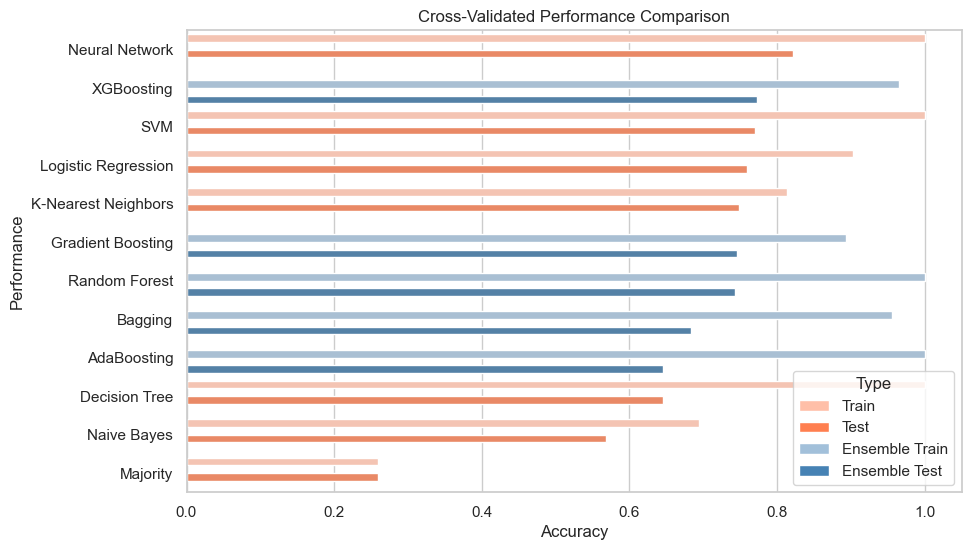

In [90]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# combine ensemble and performance set columns
result_cv_df['performance_set_ensemble'] = result_cv_df.apply(lambda row: row['performance_set'] + '_' + str(row['Ensemble Model']), axis=1)

# Use 'palette' to specify the colors for 'Train' and 'Test' sets
sns.barplot(y='Algorithm', 
            x='Performance', 
            hue='performance_set_ensemble', 
            data=result_cv_df, 
            dodge=True, 
            palette={'CV_Train_0': lighten_color('coral'), 'CV_Test_0': 'coral',
                     'CV_Train_1': lighten_color('steelblue'), 'CV_Test_1': 'steelblue'})
plt.xlabel('Accuracy')
plt.ylabel('Performance')
plt.title('Cross-Validated Performance Comparison')
plt.legend(title='Type', loc='lower right', 
           labels=['Train', 'Test', 'Ensemble Train', 'Ensemble Test'],
           handles = [plt.Rectangle((0,0),1,1,fc=lighten_color('coral')), plt.Rectangle((0,0),1,1,fc='coral'),
                      plt.Rectangle((0,0),1,1,fc=lighten_color('steelblue')), plt.Rectangle((0,0),1,1,fc='steelblue')])
plt.show()


# Hyperparameters tuning

## SVM

In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [164]:
C = list(np.logspace(1,16,num=15, endpoint=False))
# gamma = list(np.logspace(-13,-2,num=15, endpoint=False))
params = {'C': C,
          'kernel': ['linear', 'rbf','poly']}

In [165]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

In [166]:
best_svm = GridSearchCV(SVC(), param_grid= params, cv= skf, verbose= True)

In [167]:
%%time
best_svm.fit(X_train_vec, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: total: 1h 10min 49s
Wall time: 19min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0, 100000.0,
                               1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                               10000000000.0, 100000000000.0, 1000000000000.0,
                               10000000000000.0, 100000000000000.0,
                               1000000000000000.0],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=True)

In [168]:
print(best_svm.best_params_) 
# print how our model looks after hyper-parameter tuning 
print(best_svm.best_estimator_)

{'C': 10.0, 'kernel': 'linear'}
SVC(C=10.0, kernel='linear')


In [169]:
best_svm_predictions = best_svm.predict(X_test_vec)
best_svm_accuracy = accuracy_score(y_test, best_svm_predictions)
print("SVM Accuracy:", best_svm_accuracy)

SVM Accuracy: 0.8323775915306573


In [170]:
scores = best_svm.cv_results_["mean_test_score"].reshape(
    len(params['C']),
    len(params['kernel']))

In [174]:
print(scores.shape)

(15, 3)


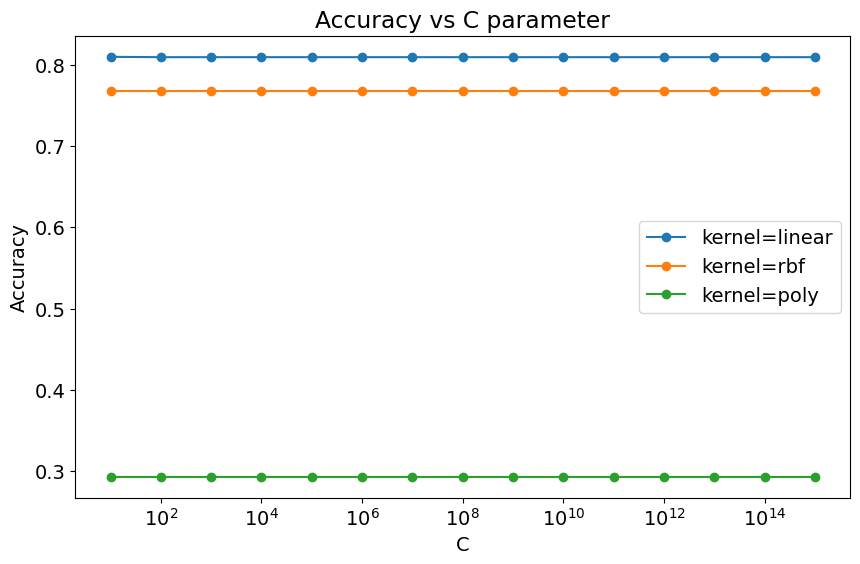

In [184]:
plt.figure(figsize=(10, 6))
plt.title("Accuracy vs C parameter")
plt.xlabel("C")
plt.ylabel("Accuracy")
n = len(params['kernel'])
for i in range(n):
    plt.plot(params['C'], 
             scores[:,i], 
             'o-', label='kernel='+str(params['kernel'][i]))
 
plt.legend()
plt.xscale('log')
plt.show()

In [187]:
C = list(np.logspace(1,16,num=15, endpoint=False))
C_params = {'C': C,
          'kernel': ['linear']}

In [188]:
best_C = GridSearchCV(SVC(), param_grid= C_params, cv= skf, verbose= True)

In [190]:
best_C.fit(X_train_vec, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [10.0, 100.0, 1000.0, 10000.0, 100000.0,
                               1000000.0, 10000000.0, 100000000.0, 1000000000.0,
                               10000000000.0, 100000000000.0, 1000000000000.0,
                               10000000000000.0, 100000000000000.0,
                               1000000000000000.0],
                         'kernel': ['linear']},
             verbose=True)

In [191]:
print(best_C.best_estimator_)
best_C_predictions = best_C.predict(X_test_vec)
best_C_accuracy = accuracy_score(y_test, best_C_predictions)
print("SVM Accuracy:", best_C_accuracy)

SVC(C=10.0, kernel='linear')
SVM Accuracy: 0.8323775915306573


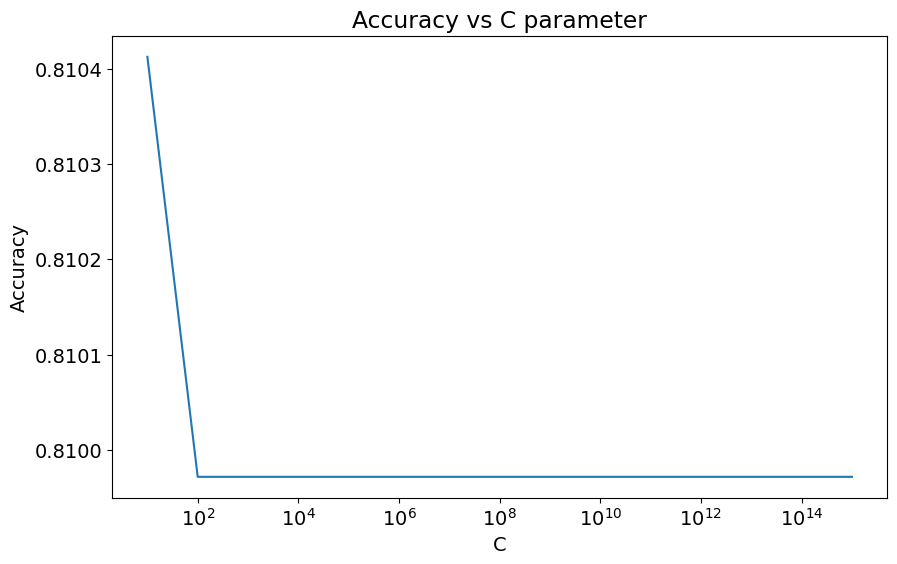

In [193]:
scores = best_C.cv_results_["mean_test_score"].reshape(
    len(params['C']))
plt.figure(figsize=(10, 6))
plt.title("Accuracy vs C parameter")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(params['C'], scores[:])
plt.xscale('log')
plt.show()

In [ ]:
import pickle
with open('ga_instance_xgb_linear.pkl', 'wb') as f:
    pickle.dump(ga_instance_xgb_linear, f)

In [ ]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method 
plot_grid_search(best_svm.cv_results_, C, max_features, 'N Estimators',

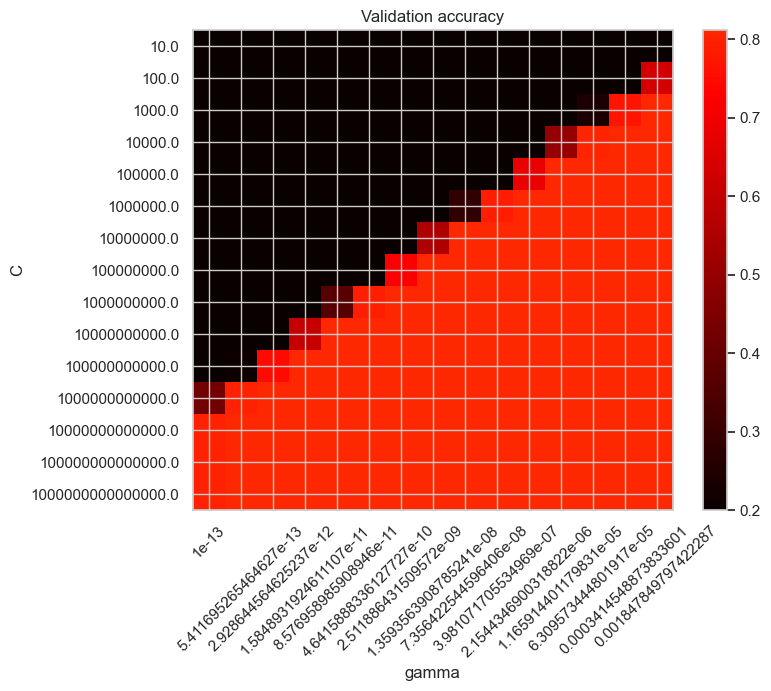

In [647]:
scores = best_svm.cv_results_["mean_test_score"].reshape(len(C), len(gamma))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma)), gamma, rotation=45)
plt.yticks(np.arange(len(C)), C)
plt.title("Validation accuracy")
plt.show()

In [194]:
def fitness_func(ga_instance, solution, solution_idx):
    # Extract C and gamma values from the solution
    C_value = solution[0]

    # Create an SVM model with the specified parameters
    svm_model = SVC(C=C_value, kernel='linear')

    # Train the SVM model
    svm_model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = svm_model.predict(X_test_vec)

    # Calculate accuracy as the fitness value
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [195]:
def on_generation(ga_instance):
    # Get the best solutions and their fitness values
    solutions = ga_instance.population
    fitness_values = ga_instance.last_generation_fitness

    # Sort solutions based on fitness values
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    top_5_indices = sorted_indices[:5]

    # Print the top 5 solutions and their accuracy
    print("\nTop 5 Solutions at Generation", ga_instance.generations_completed)
    for idx in top_5_indices:
        print("Solution:", solutions[idx])
        print("Accuracy:", fitness_values[idx])
    

In [196]:
import pygad

In [197]:
gene_space = np.array([list(np.logspace(-5,10,num=20, endpoint=False))])  # C parameter

In [200]:
gene_space = [{'low': 0.00001, 'high': 10000000000}] 

In [201]:
ga_instance = pygad.GA(num_generations=15,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=1,
                      fitness_func=fitness_func,
                      gene_space=gene_space,
                      mutation_percent_genes=5,
                      on_generation=on_generation)

c:\Users\oskik\AppData\Local\Programs\Python\Python311\Lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [619]:
from sklearnex import patch_sklearn 
patch_sklearn()
from sklearn.svm import SVC
svm_model = SVC(C=1000000, gamma=0.0001, kernel='rbf') # default kernel is rbf and default C is 1.0
# TODO: cross-validation to find the best C and kernel
svm_model.fit(X_train_vec, y_train)
svm_predictions = svm_model.predict(X_test_vec)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


SVM Accuracy: 0.8408163265306122


In [202]:
ga_instance.run()



Top 5 Solutions at Generation 1
Solution: [2.48337827e+09]
Accuracy: 0.8323775915306573
Solution: [4.29682938e+09]
Accuracy: 0.8323775915306573
Solution: [8.1204426e+09]
Accuracy: 0.8323775915306573
Solution: [6.66486364e+09]
Accuracy: 0.8323775915306573
Solution: [2.77444409e+09]
Accuracy: 0.8323775915306573


In [624]:

# Get the best solution found by the GA
best_solution = ga_instance.best_solution()

# Print the best solution and its corresponding fitness value
print("Best Solution:", best_solution[0])
print("Best Fitness Value:", best_solution[1])

# Extract the best C and gamma values
best_C = best_solution[0][0]
best_gamma = best_solution[0][1]

# Train an SVM model with the best parameters
best_svm_model = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
best_svm_model.fit(X_train_vec, y_train)

# Make predictions on the test set using the best model
y_pred_best = best_svm_model.predict(X_test_vec)

# Print the accuracy of the best model on the test set
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy of the Best Model:", accuracy_best)

Best Solution: [2.51188643e+11 1.00000000e-03]
Best Fitness Value: 0.8408163265306122
Accuracy of the Best Model: 0.8408163265306122


In [628]:
print(classification_report(y_test, svm_predictions)) 

                 precision    recall  f1-score   support

       BUSINESS       0.80      0.60      0.69        40
   FOOD & DRINK       1.00      0.66      0.79        47
  HOME & LIVING       1.00      0.63      0.77        43
MINORITY VOICES       0.73      0.83      0.78        71
        PARENTS       0.69      0.93      0.80       107
         SPORTS       0.83      0.44      0.58        34
 STYLE & BEAUTY       0.84      0.85      0.85        68
         TRAVEL       0.78      0.88      0.82        80

       accuracy                           0.78       490
      macro avg       0.83      0.73      0.76       490
   weighted avg       0.81      0.78      0.78       490



In [629]:
print(classification_report(y_test, y_pred_best)) 

                 precision    recall  f1-score   support

       BUSINESS       0.74      0.85      0.79        40
   FOOD & DRINK       1.00      0.83      0.91        47
  HOME & LIVING       0.87      0.77      0.81        43
MINORITY VOICES       0.84      0.80      0.82        71
        PARENTS       0.83      0.92      0.87       107
         SPORTS       0.88      0.62      0.72        34
 STYLE & BEAUTY       0.86      0.87      0.86        68
         TRAVEL       0.81      0.89      0.85        80

       accuracy                           0.84       490
      macro avg       0.85      0.82      0.83       490
   weighted avg       0.85      0.84      0.84       490



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


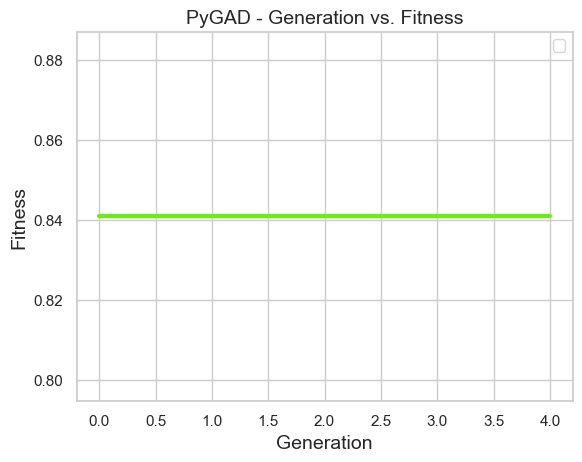

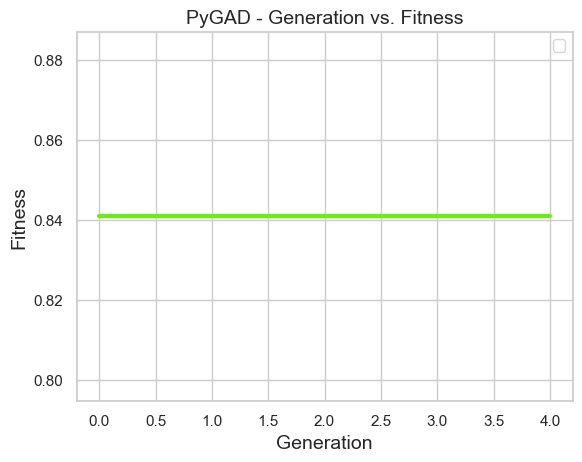

In [563]:
ga_instance.plot_fitness()

## XGBoost

In [65]:
default_parameters = model_xgb.get_params()
default_parameters

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [66]:
# expliticity fit the model with the default parameters
xgb_model_explicit = XGBClassifier(**default_parameters)
model_xgb.fit(X_train_vec, y_encoded_train)
pred_xgb = model_xgb.predict(X_test_vec)
result_xgb = accuracy_score(y_encoded_test, pred_xgb)
print("XGBoost Accuracy:", result_xgb)

XGBoost Accuracy: 0.7812086457873842


In [67]:
# CV performance of the default model
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model_xgb, X_train_vec, y_encoded_train, cv=5)
print("CV Scores:", cv_scores)
# mean CV score
print("Mean CV Score:", cv_scores.mean())

CV Scores: [0.76957001 0.77398015 0.76999448 0.77330392 0.78047435]
Mean CV Score: 0.7734645835449111


In [68]:
xgb_model_linear = XGBClassifier(booster='gblinear')
xgb_model_linear.fit(X_train_vec, y_encoded_train)
# predictions
pred_xgb_linear = xgb_model_linear.predict(X_test_vec)
result_xgb_linear = accuracy_score(y_encoded_test, pred_xgb_linear)
print("XGBoost Accuracy:", result_xgb_linear)

XGBoost Accuracy: 0.8010586678429643


In [69]:
# cv performance of the linear model
cv_scores_linear = cross_val_score(xgb_model_linear, X_train_vec, y_encoded_train, cv=5)
print("CV Scores:", cv_scores_linear)
# mean CV score
print("Mean CV Score:", cv_scores_linear.mean())

CV Scores: [0.78610805 0.78665932 0.79426365 0.7854385  0.78323221]
Mean CV Score: 0.7871403455747447


### GridSearch

In [125]:
from sklearn.model_selection import GridSearchCV
# grid search for XGBoost
grid = dict()
grid['eta'] = [0.01, 0.05, 0.075, 0.1, 0.11, 0.15, 0.2]
# define the grid search
grid['alpha'] = [0, 0.001, 0.005, 0.01, 0.05]
# grid['lambda'] = [0, 0.001, 0.005, 0.01, 0.05]
grid['n_estimators'] = [100, 200, 300]
search = GridSearchCV(XGBClassifier(booster = 'gblinear'), grid, scoring='accuracy', cv=2, n_jobs=-1, verbose=3)
# perform the search
results = search.fit(X_train_vec, y_encoded_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 2 folds for each of 105 candidates, totalling 210 fits
Mean Accuracy: 0.788
Config: {'alpha': 0, 'eta': 0.05, 'n_estimators': 200}


In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=2, scoring='accuracy', verbose=3)
results = grid_search.fit(X_train_vec, y_encoded_train)

results.best_estimator_
results.best_params_

Fitting 2 folds for each of 162 candidates, totalling 324 fits
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.713 total time=   1.3s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.8;, score=0.673 total time=   1.3s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.9;, score=0.716 total time=   1.1s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=0.9;, score=0.671 total time=   1.2s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.708 total time=   1.1s
[CV 2/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=1, subsample=1.0;, score=0.672 total time=   1.2s
[CV 1/2] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, min_child_weight=3, subsample=0.8;, score=0.662 total time=   1.6s

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'subsample': 0.9}

In [77]:
results.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=7, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [126]:
results.best_score_

0.7883435582822086

### Genetic Algorithm

In [157]:
def fitness_func_xgb(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    max_depth = int(solution[1])
    min_child_weight = int(solution[2])
    subsample = solution[3]
    colsample_bytree = solution[4]
    # TODO:... add more parameters
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                              min_child_weight=min_child_weight, subsample=subsample, 
                              colsample_bytree=colsample_bytree)

    # Train the XGB model
    xgb_model.fit(X_train_vec, y_encoded_train)

    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test_vec)

    # Calculate accuracy as the fitness value
    # print(y_pred)
    # print(y_encoded_test)
    accuracy = accuracy_score(y_encoded_test, y_pred)

    return accuracy

In [73]:
# cross-validation variant
def fitness_func_xgb(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    max_depth = int(solution[1])
    min_child_weight = int(solution[2])
    subsample = solution[3]
    colsample_bytree = solution[4]
    # TODO:... add more parameters
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                              min_child_weight=min_child_weight, subsample=subsample, 
                              colsample_bytree=colsample_bytree)

    # Calculate cross-validation scores
    cv_scores = cross_val_score(xgb_model, X_train_vec, y_encoded_train, cv=5)
    # Calculate mean CV score
    mean_cv_score = cv_scores.mean()

    return mean_cv_score

In [74]:
def on_generation(ga_instance):
    # Get the best solutions and their fitness values
    solutions = ga_instance.population
    fitness_values = ga_instance.last_generation_fitness

    # Sort solutions based on fitness values
    sorted_indices = np.argsort(fitness_values)[::-1]  # Descending order
    top_5_indices = sorted_indices[:5]

    # Print the top 5 solutions and their accuracy
    print("\nTop 5 Solutions at Generation", ga_instance.generations_completed)
    for idx in top_5_indices:
        print("Solution:", solutions[idx])
        print("Accuracy:", fitness_values[idx])

In [75]:
# gene_space = np.array([list(np.logspace(-5,15,num=50, endpoint=False)),  # C parameter
#                      list(np.logspace(-15,5,num=50, endpoint=False))])  # gamma parameter

# gene space for XGBoost
gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate
                       list(range(3, 8)),  # max_depth
                       list(range(1, 6)),  # min_child_weight
                       list(np.linspace(0.8, 1.0, num=50)),  # subsample
                       list(np.linspace(0.8, 1.0, num=50))])  # colsample_bytree

C:\Users\benjo\AppData\Local\Temp\ipykernel_26468\3793424362.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate


In [76]:
import pygad
ga_instance_xgb_tree = pygad.GA(num_generations=15,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=5,
                      fitness_func=fitness_func_xgb,
                      gene_space=gene_space,
                      mutation_percent_genes=10,
                      on_generation=on_generation)

c:\Users\benjo\AppData\Local\Programs\Python\Python310\lib\site-packages\pygad\pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resutled in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


In [82]:
ga_instance_xgb_tree.run()


Top 5 Solutions at Generation 1
Solution: [0.36307805 6.         2.         0.99591837 0.91428571]
Accuracy: 0.775449877796704
Solution: [0.20892961 7.         2.         0.82857143 0.80816327]
Accuracy: 0.7726923827727104
Solution: [0.63095734 3.         1.         0.99591837 0.8122449 ]
Accuracy: 0.7718107797962893
Solution: [0.47863009 6.         2.         0.88571429 0.8122449 ]
Accuracy: 0.7698254247317091
Solution: [0.36307805 4.         2.         0.90612245 0.91428571]
Accuracy: 0.7697156576507654

Top 5 Solutions at Generation 2
Solution: [0.36307805 6.         2.         0.99591837 0.91428571]
Accuracy: 0.775449877796704
Solution: [0.47863009 7.         2.         1.         0.8122449 ]
Accuracy: 0.7744569266068714
Solution: [0.63095734 7.         1.         0.93469388 0.8       ]
Accuracy: 0.7744561360406375
Solution: [0.47863009 6.         2.         1.         0.93061224]
Accuracy: 0.7724719972318019
Solution: [0.36307805 6.         2.         0.85306122 0.80816327]
Accur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


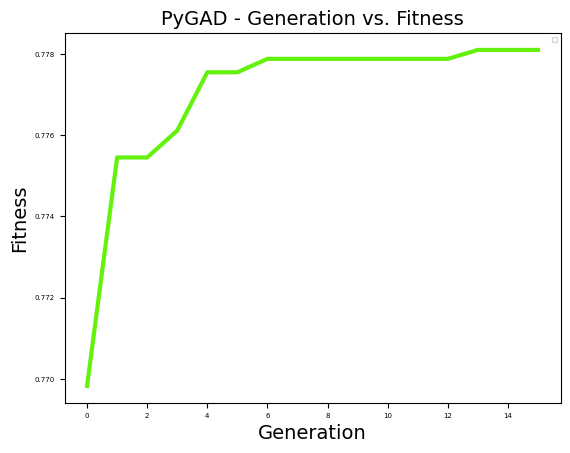

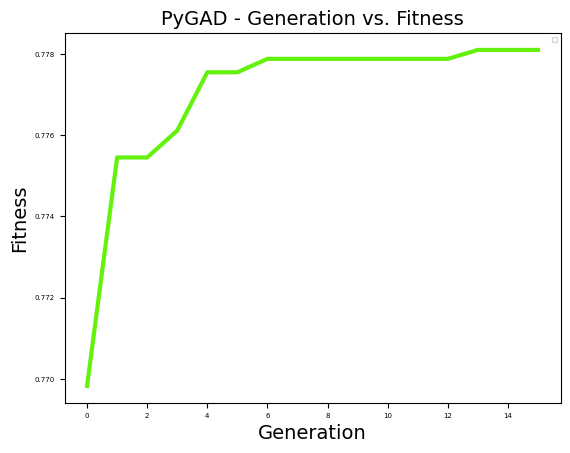

In [99]:
# plot results
ga_instance_xgb_tree.plot_fitness()

In [103]:
# save the ga instance
import pickle
with open('ga_instance_xgb_tree.pkl', 'wb') as f:
    pickle.dump(ga_instance_xgb_tree, f)

In [77]:
# load ga instance
import pickle
ga_instance_xgb_tree_pkl = pickle.load(open('ga_instance_xgb_tree.pkl', 'rb'))

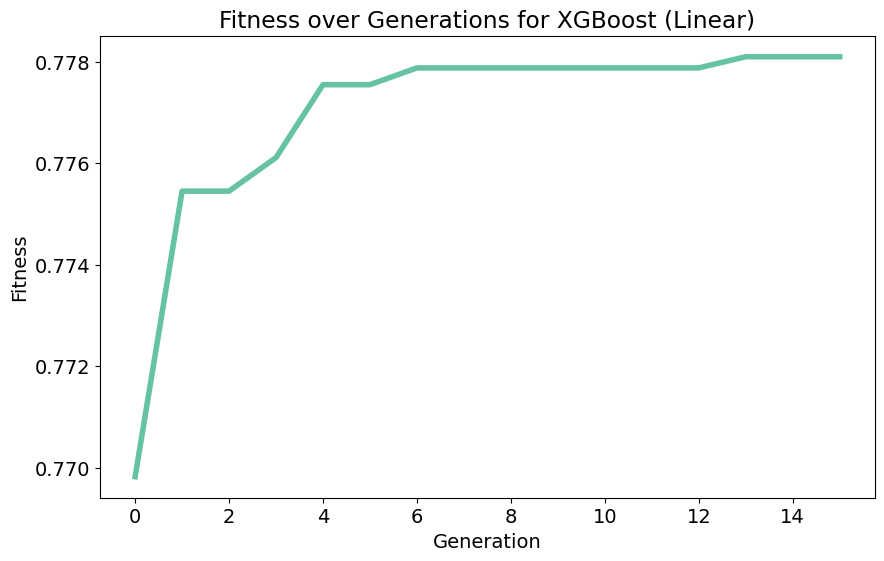

In [174]:
# create the fitness plot using matplotlib
# change fig size
plt.figure(figsize=(10, 6))
plt.plot(ga_instance_xgb_tree_pkl.best_solutions_fitness, linewidth=4)
plt.xticks(np.arange(0, ga_instance_xgb_tree_pkl.num_generations + 1, 2))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for XGBoost (Tree-based)")
plt.show()

In [78]:
# now for gblinear version
def fitness_func_xgb_linear(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    n_estimators = int(solution[1])
    alpha = solution[2]
    lambda_value = solution[3]
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                              alpha=alpha, reg_lambda=lambda_value, booster='gblinear')
    
    # Train the XGB model
    xgb_model.fit(X_train_vec, y_encoded_train)
    
    # Make predictions on the test set
    y_pred = xgb_model.predict(X_test_vec)
    
    # Calculate accuracy as the fitness value
    # print(y_pred)
    # print(y_encoded_test)
    accuracy = accuracy_score(y_encoded_test, y_pred)
    
    return accuracy
    

In [79]:
# cross validation version
# now for gblinear version
def fitness_func_xgb_linear(ga_instance, solution, solution_idx):
    # Extract parameters for XGBoost
    learning_rate = solution[0]
    n_estimators = int(solution[1])
    alpha = solution[2]
    lambda_value = solution[3]
    
    # Create XGB model with the specified parameters
    xgb_model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, 
                              alpha=alpha, reg_lambda=lambda_value, booster='gblinear')
    
    # Calculate cross-validation scores
    cv_scores = cross_val_score(xgb_model, X_train_vec, y_encoded_train, cv=5)
    # Calculate mean CV score
    mean_cv_score = cv_scores.mean()
    
    return mean_cv_score
    

In [80]:
# gene space for XGBoost
gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate
                       list(range(100, 500, 10)),  # n_estimators
                       list(np.logspace(-5,1,num=50, endpoint=False)),  # alpha
                       list(np.logspace(-5,1,num=50, endpoint=False))])  # lambda

C:\Users\benjo\AppData\Local\Temp\ipykernel_26468\3340099768.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gene_space = np.array([list(np.logspace(-5,1,num=50, endpoint=False)),  # learning_rate


In [81]:
# define the GA instance
import pygad
ga_instance_xgb_linear = pygad.GA(num_generations=10,
                      num_parents_mating=10,
                      sol_per_pop=50,
                      num_genes=4,
                      fitness_func=fitness_func_xgb_linear,
                      gene_space=gene_space,
                      mutation_percent_genes=10,
                      on_generation=on_generation)

In [89]:
# run the GA
ga_instance_xgb_linear.run()


Top 5 Solutions at Generation 1
Solution: [2.51188643e-03 4.60000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8164775287629281
Solution: [2.75422870e-01 4.80000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8080947901077055
Solution: [2.51188643e-03 2.60000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8071027511096813
Solution: [4.36515832e-03 1.60000000e+02 5.24807460e-05 3.01995172e-05]
Accuracy: 0.7760016322152092
Solution: [8.31763771e-01 4.60000000e+02 1.58489319e-04 1.31825674e-05]
Accuracy: 0.7407085054588597

Top 5 Solutions at Generation 2
Solution: [5.75439937e-03 4.80000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8180215654306062
Solution: [2.51188643e-03 4.60000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8164775287629281
Solution: [2.51188643e-03 4.60000000e+02 1.31825674e-05 2.29086765e-05]
Accuracy: 0.8103010780282792
Solution: [2.75422870e-01 3.20000000e+02 1.31825674e-05 1.00000000e-05]
Accuracy: 0.8080947901077055
Solution: [2.75422870e-01

In [101]:
ga_instance_xgb_linear.best_solution()

(array([5.75439937e-03, 3.20000000e+02, 1.31825674e-05, 1.00000000e-05]),
 0.8205579451602448,
 0)

In [107]:
# save ga instance
import pickle
with open('ga_instance_xgb_linear.pkl', 'wb') as f:
    pickle.dump(ga_instance_xgb_linear, f)

In [82]:
# load ga instance
import pickle
ga_instance_xgb_linear_pkl = pickle.load(open('ga_instance_xgb_linear.pkl', 'rb'))

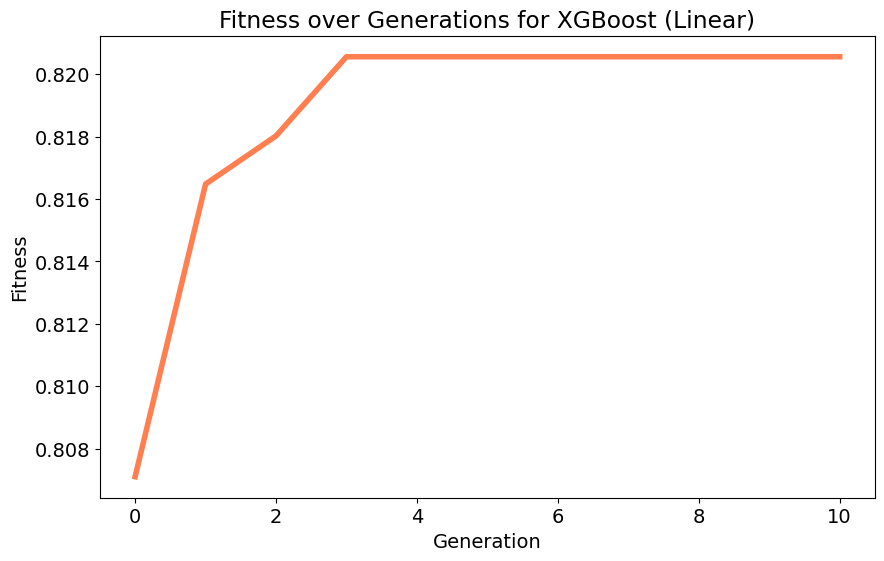

In [175]:
# create the fitness plot using matplotlib
# change fig size
plt.figure(figsize=(10, 6))
plt.plot(ga_instance_xgb_linear_pkl.best_solutions_fitness, linewidth=4, color='coral')
plt.xticks(np.arange(0, ga_instance_xgb_linear_pkl.num_generations + 1, 2))
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for XGBoost (Linear)")
plt.show()

In [70]:
# Explicitly fit the model with the best parameters
xgb_model_explicit = XGBClassifier(learning_rate=0.01, n_estimators=100, alpha=0.0001, reg_lambda=0.0001, booster='gblinear')

# Visualising Results

Illustrating the results from the tuned XGBoost model

In [60]:
# fit the XGBoost model from the GA with the best parameters
from xgboost import XGBClassifier
xgb_ga_best = XGBClassifier(learning_rate=5.75439937e-03, n_estimators=320, alpha=1.31825674e-05, reg_lambda=1.00000000e-05, booster='gblinear')

In [72]:
from sklearn.model_selection import cross_val_score
# calculate cv scores
cv_scores = cross_val_score(xgb_ga_best, X_train_vec, y_encoded_train, cv=5)
print("CV Scores:", cv_scores)
# mean CV score
print("Mean CV Score:", cv_scores.mean())

CV Scores: [0.82855568 0.81367144 0.82515168 0.82294539 0.81246553]
Mean CV Score: 0.8205579451602448


In [63]:
# Train the best xgb model from the GA on 10% of the full dataset
from sklearn.metrics import classification_report
xgb_ga_best.fit(X_train_vec, y_encoded_train)
pred_xgb_ga = xgb_ga_best.predict(X_test_vec)
# inverse transform the predictions
pred_xgb_ga = label_encoder.inverse_transform(pred_xgb_ga)

In [64]:
# Train the best xgb model from the GA on the full dataset (for CURIOSITY)
xgb_ga_full = xgb_ga_best
y_encoded_train_full = label_encoder.fit_transform(y_train_full)
xgb_ga_full.fit(X_train_full_vec, y_encoded_train_full)
pred_xgb_ga_full = xgb_ga_full.predict(X_test_full_vec)
# inverse transform the predictions
pred_xgb_ga_full = label_encoder.inverse_transform(pred_xgb_ga_full)

In [74]:
print(classification_report(y_test, pred_xgb_ga))
# accuracy
accuracy = accuracy_score(y_test, pred_xgb_ga)
print("Accuracy:", accuracy)
# aggregate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred_xgb_ga, average='weighted')
print("F1 Score:", f1)
# aggregate precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, pred_xgb_ga, average='weighted')
print("Precision:", precision)
# aggregate recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, pred_xgb_ga, average='weighted')
print("Recall:", recall)

                 precision    recall  f1-score   support

       BUSINESS       0.78      0.45      0.57        87
  ENTERTAINMENT       0.82      0.84      0.83       345
   FOOD & DRINK       0.94      0.74      0.83        90
  HOME & LIVING       0.98      0.70      0.82        70
MINORITY VOICES       0.88      0.62      0.73       159
        PARENTS       0.80      0.79      0.80       198
       POLITICS       0.85      0.95      0.90       587
         SPORTS       0.96      0.62      0.75        71
 STYLE & BEAUTY       0.92      0.83      0.87       144
         TRAVEL       0.84      0.82      0.83       159
       WELLNESS       0.73      0.92      0.82       357

       accuracy                           0.83      2267
      macro avg       0.86      0.75      0.80      2267
   weighted avg       0.84      0.83      0.83      2267

Accuracy: 0.8306131451257168
F1 Score: 0.8263290490967112
Precision: 0.8382085293694125
Recall: 0.8306131451257168


In [65]:
print(classification_report(y_test_full, pred_xgb_ga_full))
# accuracy
accuracy = accuracy_score(y_test_full, pred_xgb_ga_full)
print("Accuracy:", accuracy)
# aggregate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test_full, pred_xgb_ga_full, average='weighted')
print("F1 Score:", f1)
# aggregate precision
from sklearn.metrics import precision_score
precision = precision_score(y_test_full, pred_xgb_ga_full, average='weighted')
print("Precision:", precision)
# aggregate recall
from sklearn.metrics import recall_score
recall = recall_score(y_test_full, pred_xgb_ga_full, average='weighted')
print("Recall:", recall)

                 precision    recall  f1-score   support

       BUSINESS       0.84      0.57      0.68       867
  ENTERTAINMENT       0.87      0.89      0.88      3446
   FOOD & DRINK       0.91      0.87      0.89       896
  HOME & LIVING       0.96      0.84      0.90       697
MINORITY VOICES       0.88      0.68      0.77      1587
        PARENTS       0.86      0.85      0.86      1984
       POLITICS       0.88      0.95      0.91      5875
         SPORTS       0.91      0.73      0.81       717
 STYLE & BEAUTY       0.93      0.91      0.92      1443
         TRAVEL       0.91      0.89      0.90      1591
       WELLNESS       0.82      0.92      0.87      3565

       accuracy                           0.87     22668
      macro avg       0.89      0.83      0.85     22668
   weighted avg       0.88      0.87      0.87     22668

Accuracy: 0.8741397564849126
F1 Score: 0.8716450617822091
Precision: 0.8753578711097231
Recall: 0.8741397564849126


## Confusion Matrix

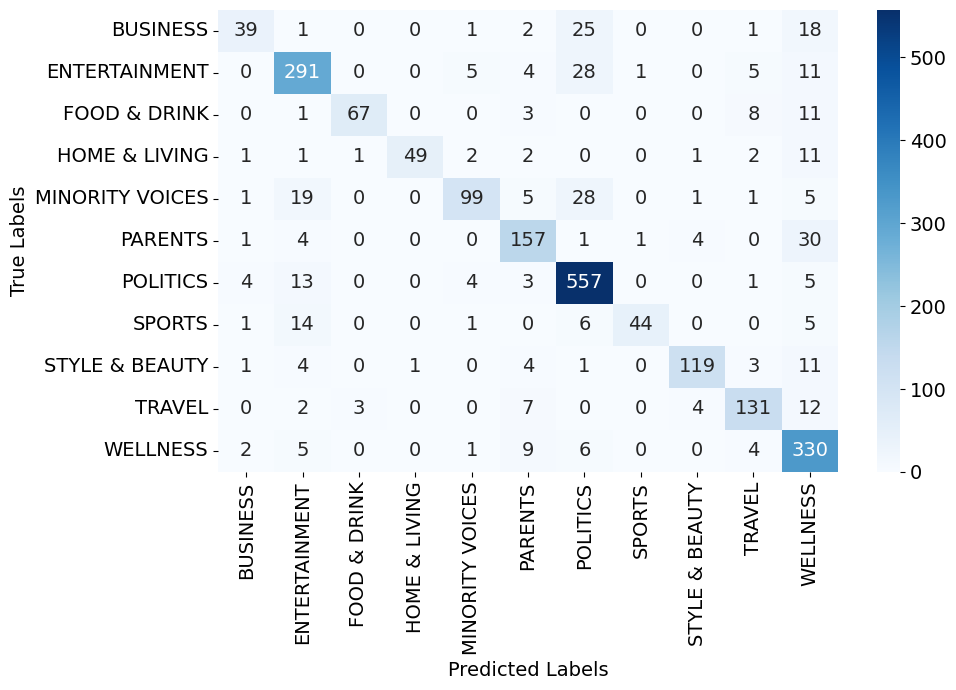

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming label_encoder is your label encoder
# If not, replace this with your actual label encoding logic
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Create the confusion matrix
cm = confusion_matrix(y_test, pred_xgb_ga)

# Get the class labels from the label encoder
class_labels = label_encoder.classes_

# Plot the confusion matrix with Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')

# Set axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

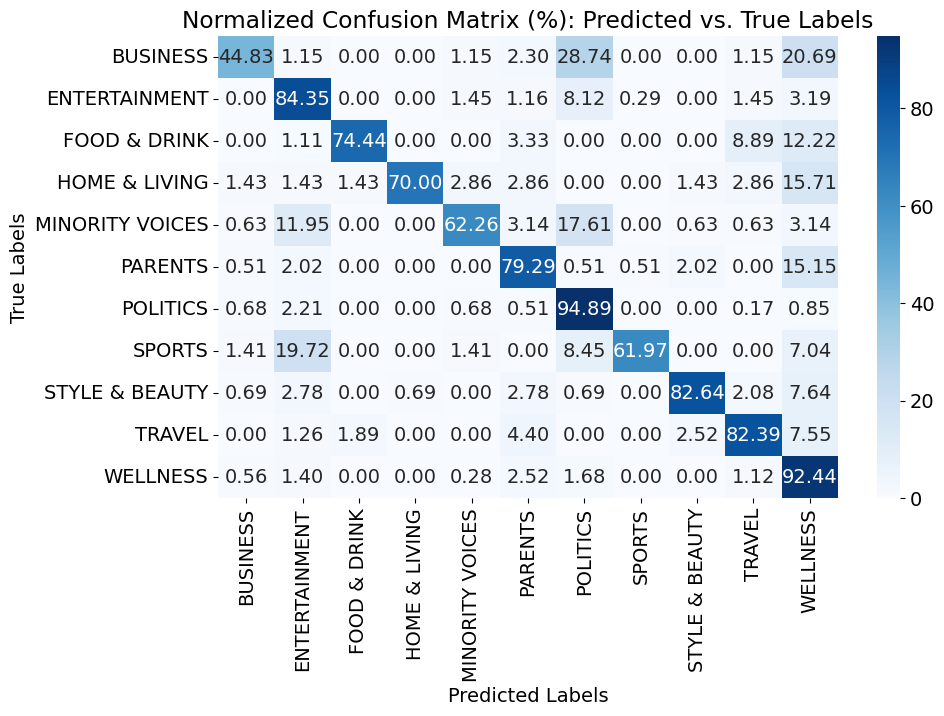

In [76]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Assuming label_encoder is your label encoder
# If not, replace this with your actual label encoding logic
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

# Create the confusion matrix
cm = confusion_matrix(y_test, pred_xgb_ga)

# Calculate row-wise sums
row_sums = cm.sum(axis=1, keepdims=True)

# Standardize each row to be a percentage
cm_percentage = np.round((cm / row_sums) * 100, 2)

# Get the class labels from the label encoder
class_labels = label_encoder.classes_

# Plot the confusion matrix with Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')

# Set axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (%): Predicted vs. True Labels')

# Show the plot
plt.show()


## Prediction Confidence

In [70]:
# prediction probabilities for XGBoost Default
pred_probs = xgb_ga_best.predict_proba(X_test_vec)

In [72]:
# Create df with predictions probabilities for each class for each document in the test set
class_labels = label_encoder.classes_
pred_probs_df = pd.DataFrame(pred_probs, columns=class_labels)
# add column for true labels
pred_probs_df['True_Label'] = y_test.tolist()
# add column for predicted labels
pred_probs_df['Predicted_Label'] = pred_xgb_ga

In [80]:
pred_probs_df.head()

,BUSINESS,ENTERTAINMENT,FOOD & DRINK,HOME & LIVING,MINORITY VOICES,PARENTS,POLITICS,SPORTS,STYLE & BEAUTY,TRAVEL,WELLNESS,True_Label,Predicted_Label
0,0.012412,0.058941,0.042569,0.015962,0.035279,0.073315,0.031507,0.010078,0.121037,0.014256,0.584645,WELLNESS,WELLNESS
1,0.041216,0.042515,0.531821,0.034281,0.058991,0.060410,0.032149,0.036178,0.037969,0.051509,0.072962,FOOD & DRINK,FOOD & DRINK
2,0.013234,0.029740,0.006080,0.007261,0.029476,0.006159,0.812152,0.007693,0.007841,0.059642,0.020722,POLITICS,POLITICS
3,0.004155,0.016320,0.003617,0.004658,0.008458,0.880270,0.008174,0.005777,0.009478,0.006306,0.052787,PARENTS,PARENTS
4,0.001352,0.013246,0.001083,0.002157,0.006241,0.941188,0.022551,0.003980,0.004938,0.001541,0.001722,PARENTS,PARENTS


In [81]:
# filter the dataframe for a more readable plot

# filter to show most ambiguous predictions
pred_probs_df_ambiguous = pred_probs_df[(pred_probs_df.max(axis=1) > 0.4) & (pred_probs_df.max(axis=1) < 0.6)]
pred_probs_df.shape

# filter to show most confident predictions
pred_probs_df_confident = pred_probs_df[pred_probs_df.max(axis=1) > 0.9]
pred_probs_df_confident.shape

# filter to show predictions where the model is most wrong
pred_probs_df_wrong = pred_probs_df[pred_probs_df['Predicted_Label'] != pred_probs_df['True_Label']]
pred_probs_df_wrong.shape

# filter to show where predictions of business were wrong
pred_probs_df_business_wrong = pred_probs_df[(pred_probs_df['True_Label'] == 'BUSINESS') & (pred_probs_df['Predicted_Label'] != pred_probs_df['True_Label'])]
pred_probs_df_business_wrong.shape

C:\Users\benjo\AppData\Local\Temp\ipykernel_27504\1403449880.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred_probs_df_ambiguous = pred_probs_df[(pred_probs_df.max(axis=1) > 0.4) & (pred_probs_df.max(axis=1) < 0.6)]
C:\Users\benjo\AppData\Local\Temp\ipykernel_27504\1403449880.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred_probs_df_confident = pred_probs_df[pred_probs_df.max(axis=1) > 0.9]


(48, 13)

In [82]:
pred_probs_df_business_wrong

,BUSINESS,ENTERTAINMENT,FOOD & DRINK,HOME & LIVING,MINORITY VOICES,PARENTS,POLITICS,SPORTS,STYLE & BEAUTY,TRAVEL,WELLNESS,True_Label,Predicted_Label
82,0.147590,0.132119,0.035653,0.017105,0.110339,0.063697,0.272822,0.027210,0.036452,0.024357,0.132657,BUSINESS,POLITICS
152,0.064270,0.019293,0.013902,0.008990,0.020535,0.029533,0.728148,0.016833,0.020314,0.030156,0.048028,BUSINESS,POLITICS
244,0.241365,0.047655,0.028471,0.027559,0.099206,0.046378,0.250249,0.084723,0.039040,0.039343,0.096010,BUSINESS,POLITICS
275,0.238905,0.052836,0.034957,0.025578,0.050949,0.095859,0.338391,0.028874,0.040511,0.044550,0.048589,BUSINESS,POLITICS
352,0.282559,0.022987,0.014538,0.013491,0.026581,0.028279,0.066431,0.029857,0.014875,0.020019,0.480382,BUSINESS,WELLNESS
431,0.230552,0.071047,0.016007,0.017893,0.051367,0.031294,0.375394,0.035162,0.024358,0.034435,0.112490,BUSINESS,POLITICS
461,0.074100,0.045577,0.034923,0.066263,0.028530,0.118340,0.028080,0.011017,0.039759,0.016467,0.536944,BUSINESS,WELLNESS
533,0.164664,0.042073,0.034338,0.022534,0.047675,0.245966,0.090852,0.014711,0.069162,0.065389,0.202636,BUSINESS,PARENTS
540,0.050220,0.087988,0.005717,0.013721,0.355470,0.054458,0.220972,0.069455,0.038367,0.011492,0.092139,BUSINESS,MINORITY VOICES
584,0.214553,0.047735,0.028947,0.027696,0.039957,0.036394,0.404674,0.020484,0.028007,0.030758,0.120796,BUSINESS,POLITICS


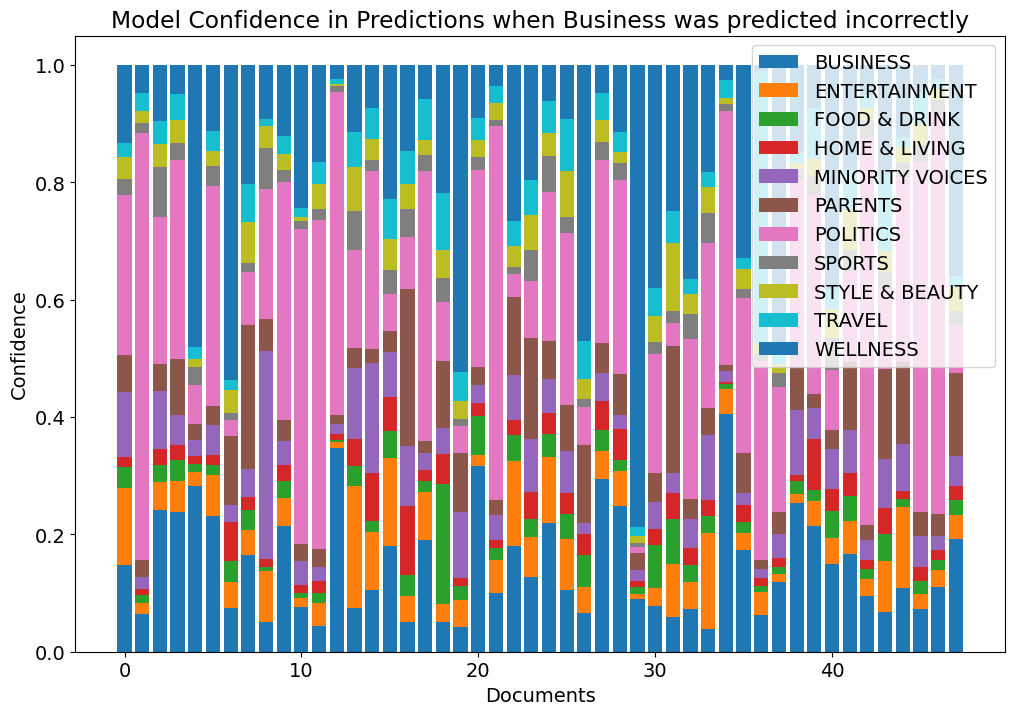

In [83]:
# plot business wrong
#TODO: NEED A LARGE COLOR PALETTE

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Stacked bar chart
bottom = np.zeros(pred_probs_df_business_wrong.shape[0])

for i, label in enumerate(class_labels):
    confidence_values = pred_probs_df_business_wrong[label]
    ax.bar(range(len(confidence_values)), confidence_values, label=label, bottom=bottom)
    bottom += confidence_values
    
# Set labels and title
ax.set_xlabel('Documents')
ax.set_ylabel('Confidence')
ax.set_title('Model Confidence in Predictions when Business was predicted incorrectly')

# Set legend
ax.legend()
plt.show()

In [73]:
grouped_df = pred_probs_df[['True_Label', 'Predicted_Label']].groupby('True_Label')

result_df = grouped_df.apply(lambda x: pd.Series({
    'Correct': (x['True_Label'] == x['Predicted_Label']).sum(),
    'Incorrect': (x['True_Label'] != x['Predicted_Label']).sum()
}))

result_df = result_df.reset_index()
print(result_df)

         True_Label  Correct  Incorrect
0          BUSINESS       39         48
1     ENTERTAINMENT      291         54
2      FOOD & DRINK       67         23
3     HOME & LIVING       49         21
4   MINORITY VOICES       99         60
5           PARENTS      157         41
6          POLITICS      557         30
7            SPORTS       44         27
8    STYLE & BEAUTY      119         25
9            TRAVEL      131         28
10         WELLNESS      330         27


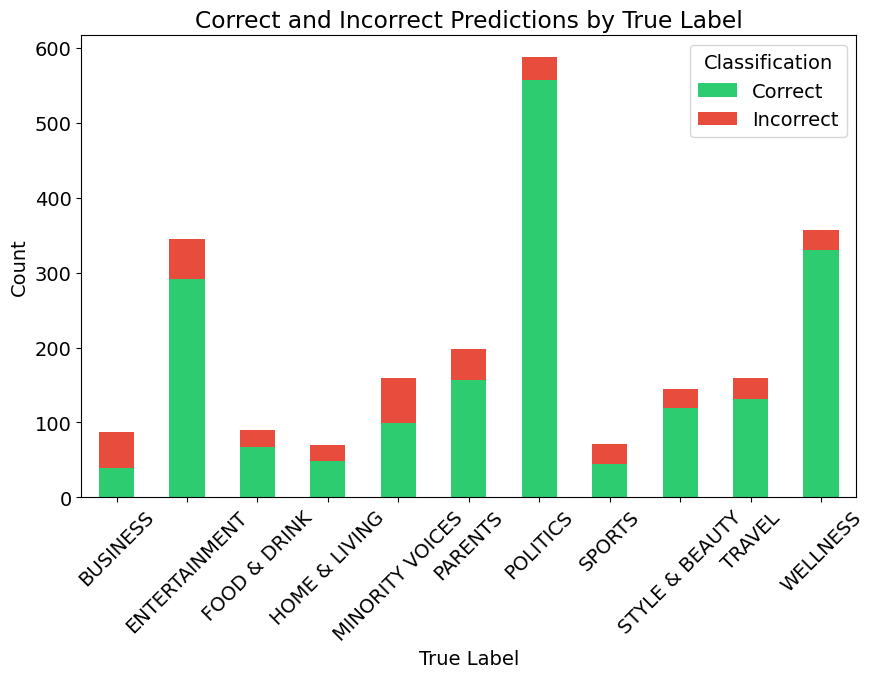

In [79]:
# Plotting the stacked bar plot
result_df.set_index('True_Label').plot(kind='bar', stacked=True, figsize=(10, 6), color=['#2ECC71', '#E74C3C'])

# Adding labels and title
plt.xlabel('True Label')
plt.ylabel('Count')
plt.title('Correct and Incorrect Predictions by True Label')

# Adding legend
plt.legend(title='Classification', bbox_to_anchor=(1, 1))

# rotate x ticks
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [67]:
import matplotlib.pyplot as plt

# Assuming result_df is already created from the previous code

# Calculate percentages
result_df['Percentage Correct'] = (result_df['Correct'] / (result_df['Correct'] + result_df['Incorrect'])) * 100
result_df['Percentage Incorrect'] = (result_df['Incorrect'] / (result_df['Correct'] + result_df['Incorrect'])) * 100

# Plotting the stacked bar plot
result_df.set_index('True_Label')[['Percentage Correct', 'Percentage Incorrect']].plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('True Label')
plt.ylabel('Percentage')
plt.title('Correct and Incorrect Prediction Percentages by True Label')

# Adding legend
plt.legend(title='Performance', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


NameError: name 'result_df' is not defined